In [8]:
import sys
import numpy as np
from pyDOE import lhs
import torch
from torch import Tensor, ones, stack, load
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy import stats
from tesladatapinn import TeslaDatasetPinn
from pathlib import Path
import wandb
import time

# Import PINNFramework
sys.path.append("....") 
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


## Preprocessing

In [9]:
# # login wandb
# wandb.login()

# # Initialize WandB 
# wandb.init(name='pinn_run_env hard tanh', 
#            project='pinn_project',
#            #notes='...', 
#            #tags=['...'],
#            #entity='...'
#            )

# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# WandB Configurations (optional)
wandb.config.normalize = 1000
wandb.config.batch_size= 1   
wandb.config.lr = 1e-5
wandb.config.ic_weight = 1

# Create instance of the dataset
id = -1
ds = TeslaDatasetPinn(battery_level = True, ID = id, data = 'train', diff = "central_diff",device = device, normalize = wandb.config.normalize)

# trainloader
train_loader = DataLoader(ds, batch_size=wandb.config.batch_size,shuffle=False)

model = pf.models.MLP(input_size=5,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=ds.lb, 
                      ub=ds.ub,
                      activation = torch.relu
                      )
model.to(device)


# dsstb = TeslaDatasetNoStb(device = device, data ="train", normalize = wandb.config.normalize, rel_time = True, ID = id, diff = "central_diff")

# # trainloader
# train_loaderstb = DataLoader(dsstb, batch_size=wandb.config.batch_size,shuffle=True)

# modelstb = pf.models.MLP(input_size=6,
#                       output_size=1, 
#                       hidden_size=100, 
#                       num_hidden=4, 
#                       lb=dsstb.lb, 
#                       ub=dsstb.ub,
#                       activation = torch.relu
#                       )

# modelstb.to(device)


# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=wandb.config.lr)
criterion = torch.nn.MSELoss()

# Log the network weight histograms (optional)
#wandb.watch(model)

cpu
(445266, 10)


## Function for writing a checkpoint during training

In [ ]:
def write_checkpoint(checkpoint_path, epoch, min_mlp_loss, optimizer):
    checkpoint = {}
    checkpoint["epoch"] = epoch
    checkpoint["minimum_pinn_loss"] = min_mlp_loss
    checkpoint["optimizer"] = optimizer.state_dict()
    checkpoint["mlp_model"] = model.state_dict()
    torch.save(checkpoint, checkpoint_path)

## Function for calculating a derivative

In [13]:
def derivative(x, u):

    grads = ones(u.shape, device=u.device) # move to the same device as prediction
    grad_u = grad(u, x, create_graph=True, grad_outputs=grads )[0]
   
    # calculate first order derivatives
    u_t = grad_u[:, 4]
       
    u_t = u_t.reshape(-1, 1)

    return u_t

## Training of PINN with hard encoded initial conditions


In [ ]:
x_data_plot=[]
y_data_all_plot=[]
y_data_1_plot=[]
y_data_2_plot=[]

# Set fixed random number seed
torch.manual_seed(1234)

start_epoch = 0
epochs = 500
min_mlp_loss = np.inf


begin = time.time()
for epoch in range(epochs):
    # Print epoch
    print(f'Starting epoch {epoch}')
    
    # Set current and total loss value
    current_loss = 0.0
    total_loss = 0.0
    total_loss1 = 0.0
    total_loss2 = 0.0
    
    model.train()  
    for i, data in enumerate(train_loader,0):
        #print(i)
        x_batch, y_batch, temp,ids = data
        optimizer.zero_grad()

        x_batch = torch.squeeze(x_batch, 0)
        y_batch = torch.squeeze(y_batch, 0)
        temp = torch.squeeze(temp, 0)

        #xmy=x_batch[:,:5]
        #print(xmy)

        # Universal Approximator
        def g(x):
          return x[:,4].reshape(-1,1).to(device) * model(x.to(device)) + temp[0, :].to(device)

        x0 = x_batch[0,:]
        
        #x.requires_grad=True
        x_batch.requires_grad=True
        u_pred = g(x_batch)

        u_t = derivative(x_batch,u_pred)*wandb.config.normalize
        
        #loss = criterion(u_t.to(device).squeeze(),modelstb(x_batch.to(device)).squeeze())
        loss = criterion(u_t.squeeze(),y_batch.squeeze())

        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_loss += loss.item()

        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.8f' %
                  (i + 1, current_loss / 50))
            current_loss = 0.0
    
    Loss = total_loss/(i+1)
    print("Epoch ", epoch, "Total Loss ", Loss )

    x_data_plot.append(epoch)
    y_data_all_plot.append(Loss)
    
    # # save best model
    # if min_mlp_loss > Loss:
    #     print(f'Validation Loss Decreased({min_mlp_loss:.6f}--->{Loss:.6f}) \t Saving The Model')
    #     min_mlp_loss = Loss
    #     # Saving State Dict
    #     model_name_path = Path('/content/drive/MyDrive/pinnmodel/best_model_env_{}_{}.pt'.format(wandb.run.id, wandb.run.name))
    #     torch.save(model.state_dict(), model_name_path)
        
    # # writing checkpoint
    # if (epoch + 1) % 200 == 0:
    #     checkpoint_path = Path('/content/drive/MyDrive/pinnmodel/checkpoint_env_{}_{}_{}.pt'.format(wandb.run.id, wandb.run.name, epoch))
    #     write_checkpoint(checkpoint_path, epoch, min_mlp_loss, optimizer)
        
    # # Log the loss and accuracy values at the end of each epoch
    # wandb.log({
    #     "Epoch": epoch,
    #     "Total Loss": Loss,
    #     })
end = time.time()        


In [ ]:
print("Training time:", end - begin)

time: 472.23584365844727


## Plot of Loss against epochs

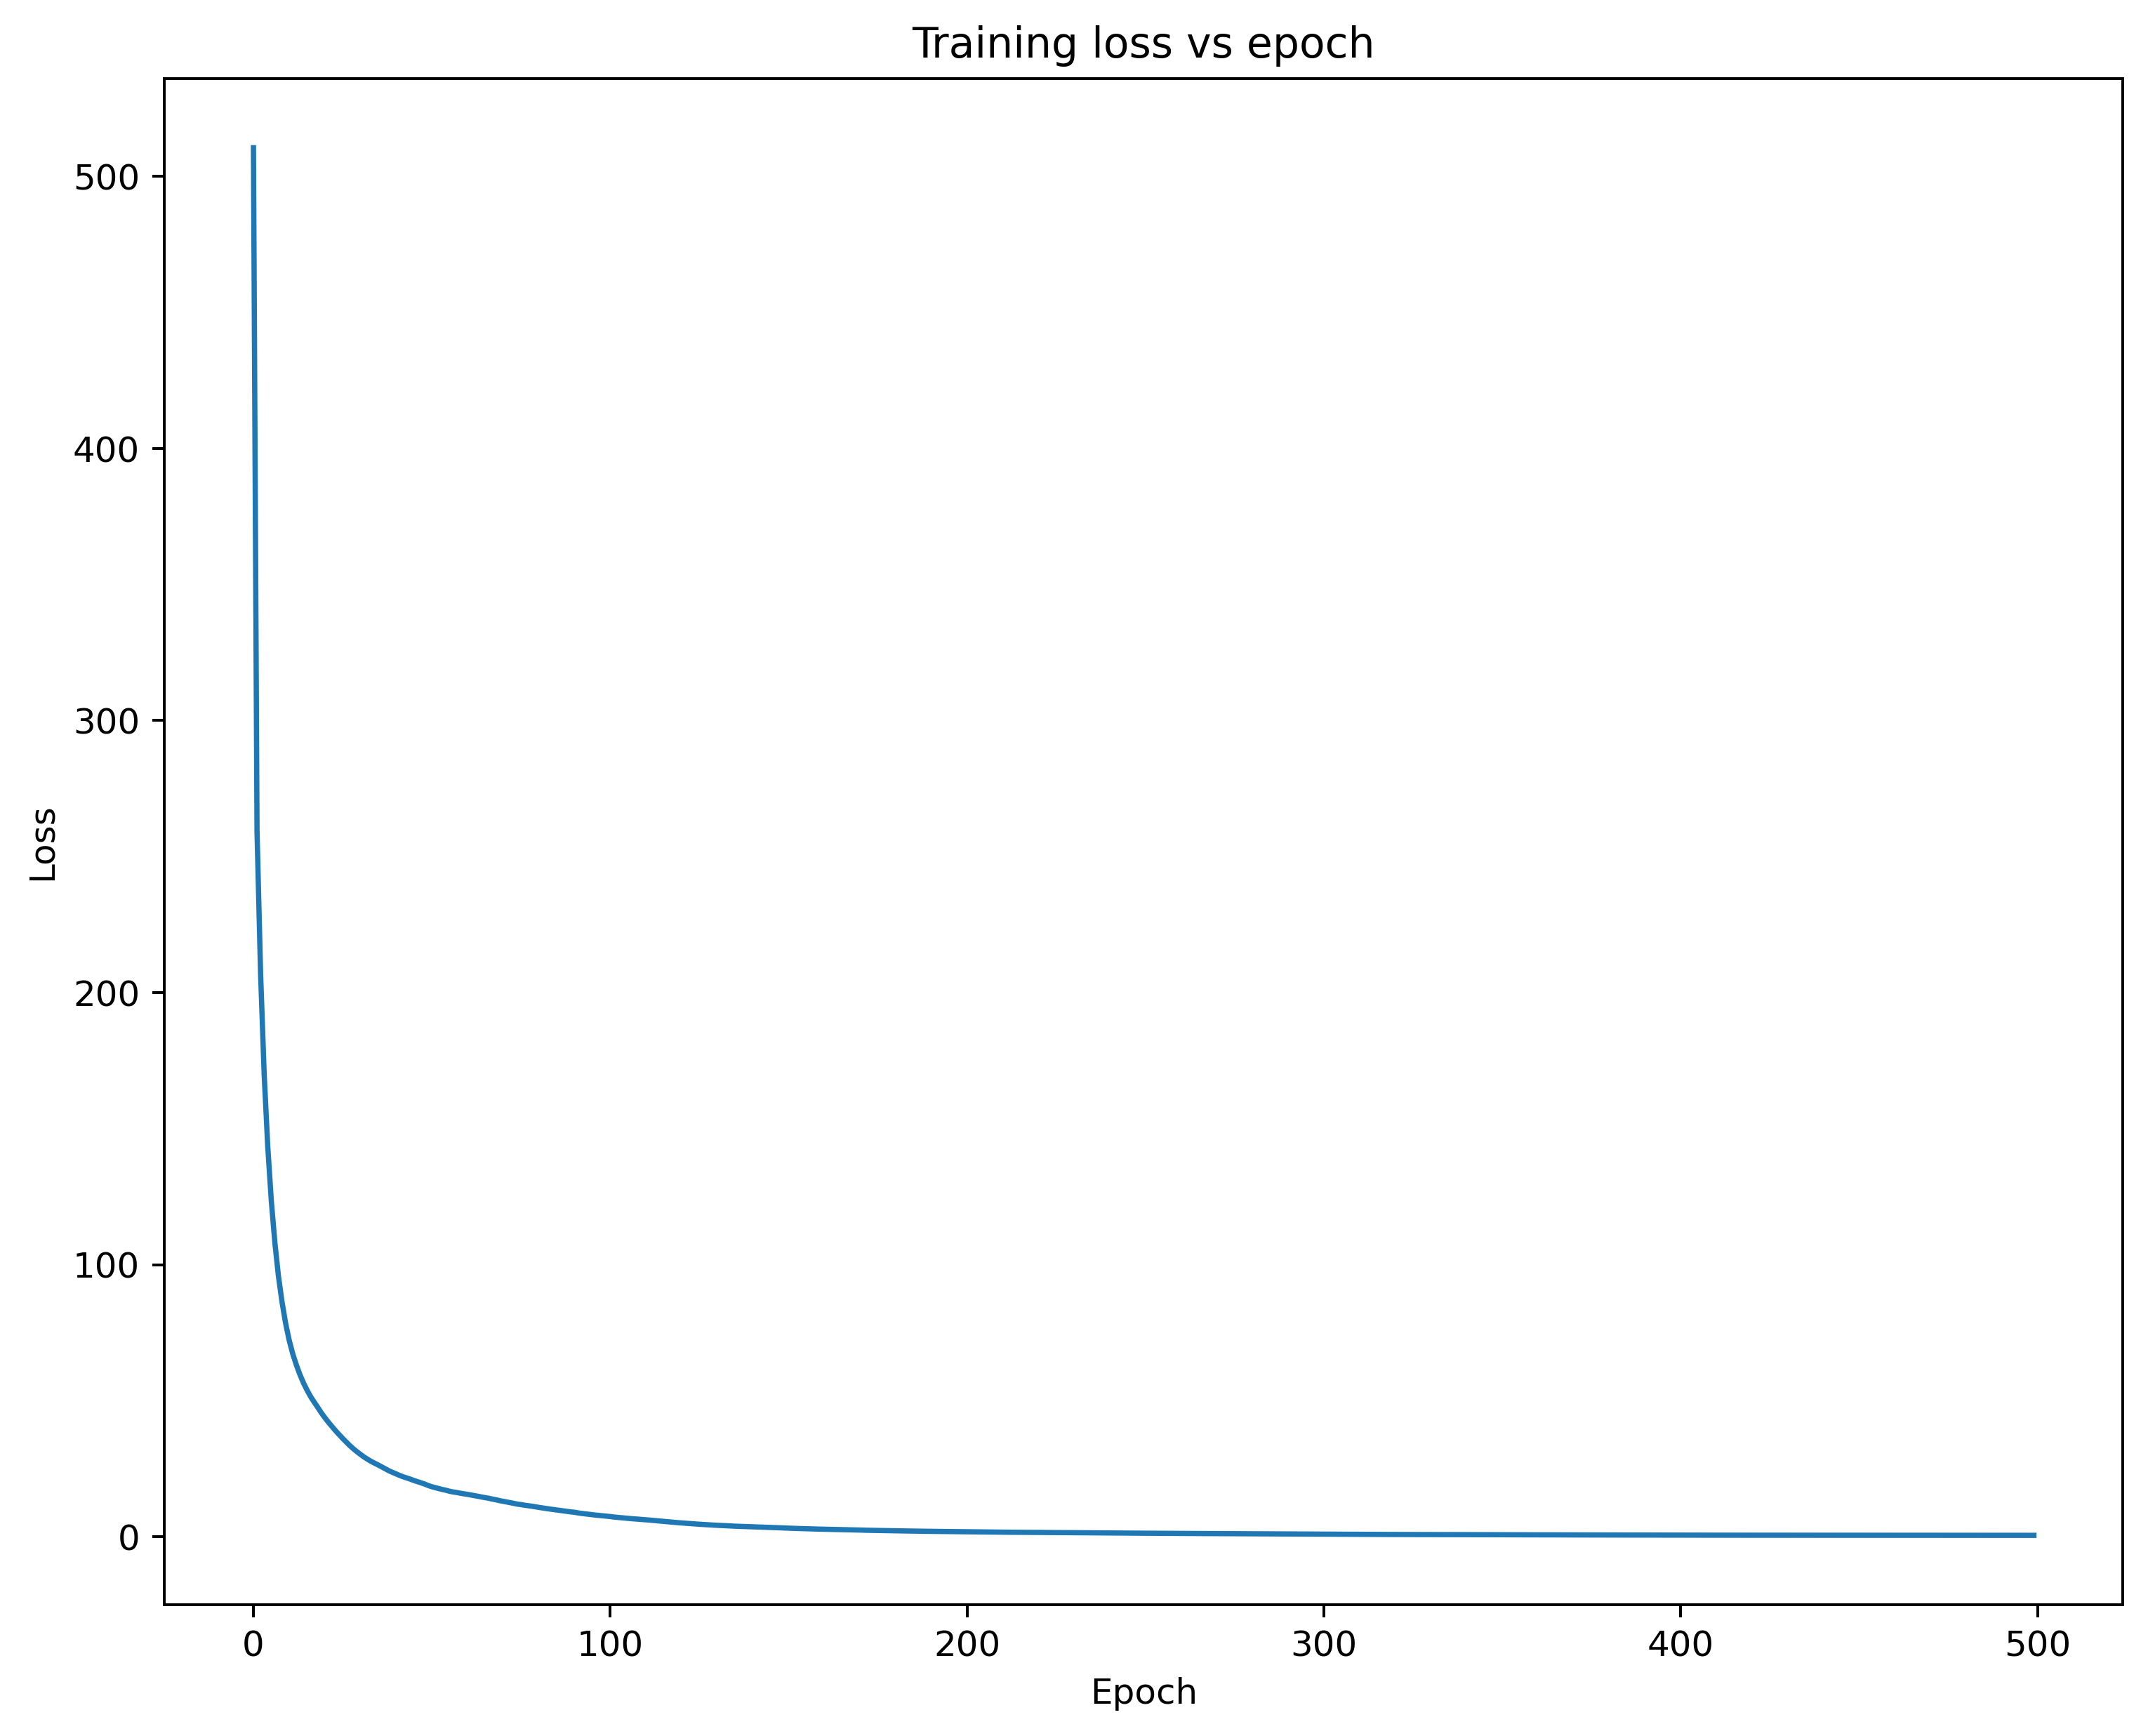

In [ ]:
# Make the plot of Total Loss vs epochs
dpi = 360
figure(figsize=(10, 8), dpi = dpi)
plt.plot(x_data_plot,y_data_all_plot)
plt.title('Training loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Postprocessing -- Load the model

In [23]:
PATH ="/pinnmodel/best_model_hard_21gywuy9.pt" # best model
#model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu'))) # uncomment if GPU is not available
model.load_state_dict(torch.load(PATH))
model.eval()

MLP(
  (linear_layers): ModuleList(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [24]:
normalize = wandb.config.normalize

# function for evaluation on test data
def evaluate(idd, bl):
    
    ds_test = TeslaDatasetPinn(device = device, normalize = wandb.config.normalize, battery_level = bl, ID = idd, data = 'test', diff = "central_diff")
    
    # time
    t = ds_test.t.numpy()
    
    # true temperature
    true_temp1 = ds_test.temp
    
    def g(x,temp):
        return x[:,4].reshape(-1,1).to(device) * model(x.to(device))  + temp[0, :].to(device)


    begin = time.time()
    pred_temp = g(ds_test.x,true_temp1)
    end = time.time() 
    print("time:", end - begin)
    pred_temp = pred_temp.detach().cpu().numpy()

    #MAE
    true_temp = ds_test.temp.numpy()
    mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
    print('MAE:', mae)

    #MSE
    mse = ((true_temp - pred_temp)**2).mean(axis=None)
    print('MSE:', mse)

    #Relative error
    rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
    print('Relative error (%):', rel_error*100)

    figure(figsize=(8, 6), dpi= 360)
    plt.plot(t, pred_temp, '--', label='PINN')
    plt.plot(t, true_temp, '-', label='Ground-truth')
    plt.title('PINN vs ground-truth for drive ID = {}'.format(idd))
    plt.xlabel('t (seconds)')
    plt.ylabel('Temperature (°C)')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()
  
    #################################################################################### 
    # Calculations for time derivative of the PINN predictions
    #ds_test.x.requires_grad=True
    x= ds_test.x
    x.requires_grad=True
    begin = time.time()
    pred = g(x,true_temp1)
    #pred = pred.detach().cpu().numpy()/normalize
    end = time.time() 
    print("time:", end - begin)
    
    # ground-truth temperature
    gt = ds_test.temp.detach().numpy()/normalize
    # calculate time derivative of the prediction
    u_t = derivative(x,pred)

    t = ds_test.t.numpy()
    ds_test.y = ds_test.y/normalize

    mae = np.sum(np.abs(u_t.detach().numpy() - ds_test.y.detach().numpy() ).mean(axis=None))
    print('MAE:', mae)

    mse = ((u_t.detach().numpy() - ds_test.y.detach().numpy())**2).mean(axis=None)
    print('MSE:', mse)

    rel_error = np.linalg.norm(u_t.detach().numpy() - ds_test.y.detach().numpy()) / np.linalg.norm(ds_test.y.detach().numpy())
    print('Relative error (%):', rel_error*100)

    figure(figsize=(8, 6), dpi= 360)
    plt.plot(t, u_t.detach().numpy(), '--', label='PINN')
    plt.plot(t, ds_test.y, '-', label='Ground-truth')
    plt.title('PINN vs ground-truth for drive-ID = {}'.format(idd))
    plt.xlabel('t (seconds)')
    plt.ylabel('ΔTemp/Δt (°C/s)')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


(4901, 10)
time: 0.013912439346313477
MAE: 0.8638527
MSE: 1.4679922
Relative error (%): 26.104429364204407


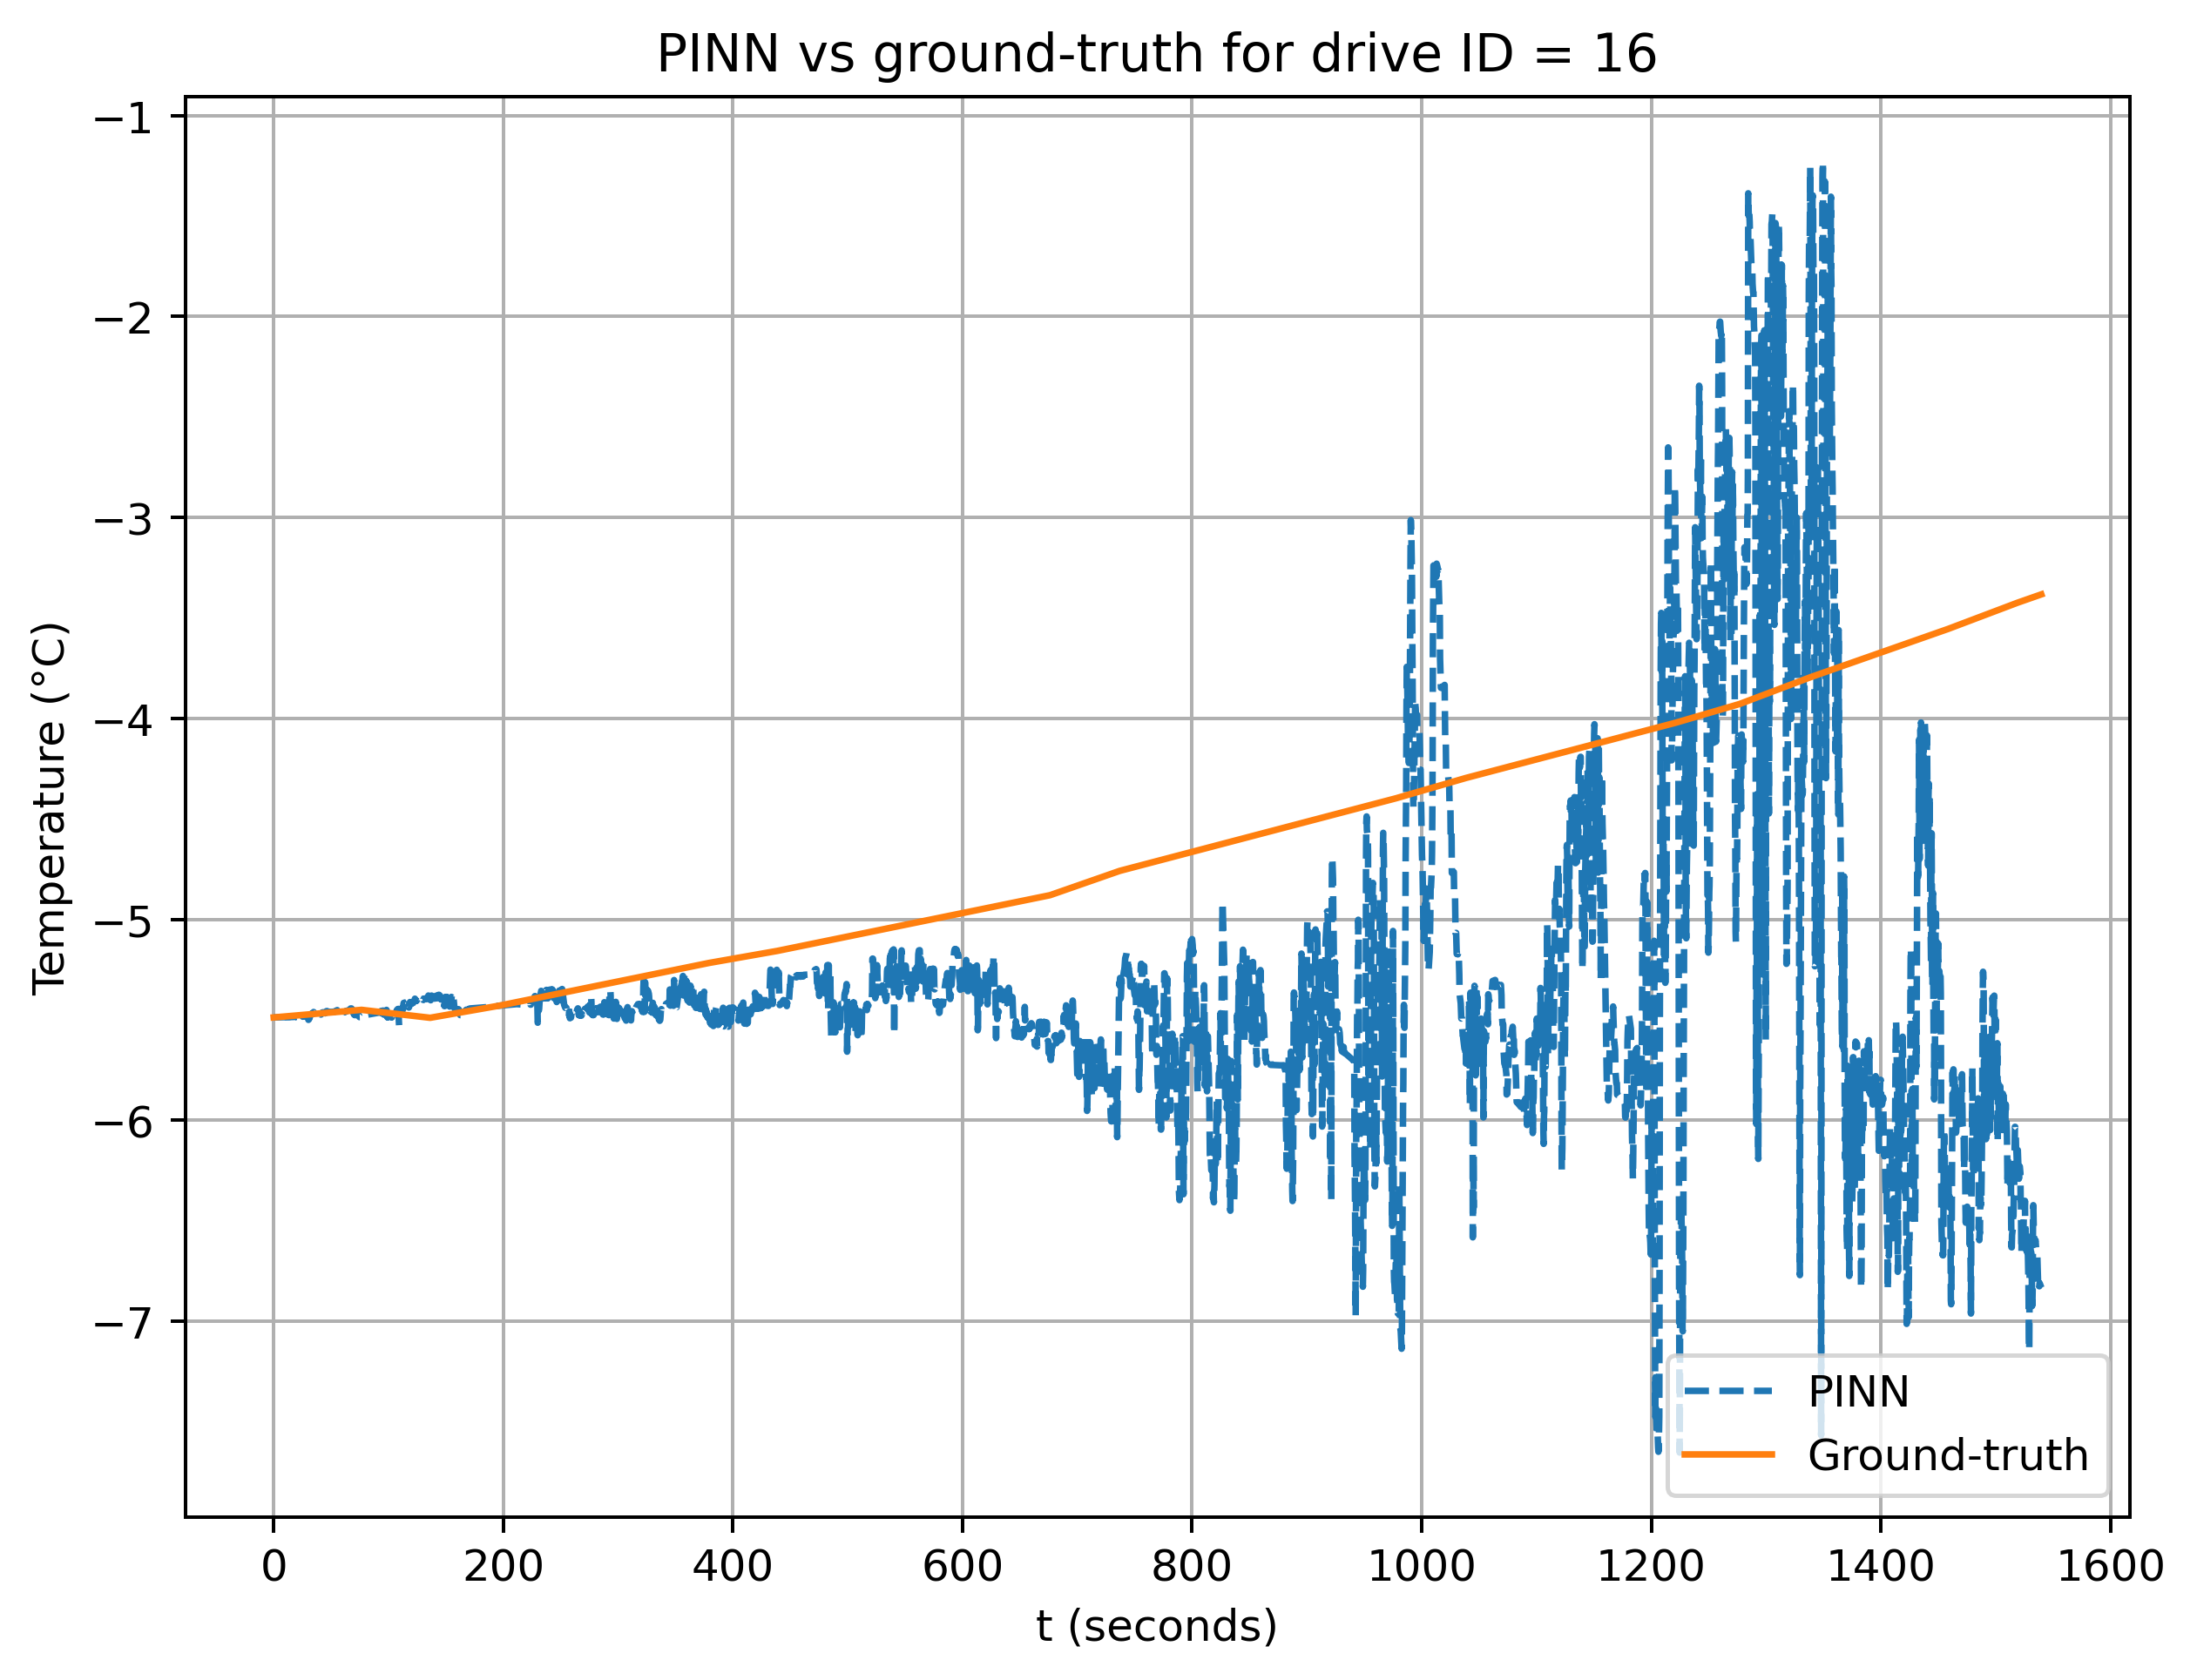

time: 0.020149707794189453
MAE: 0.0014831435
MSE: 3.7500124e-06
Relative error (%): 128.2030701637268


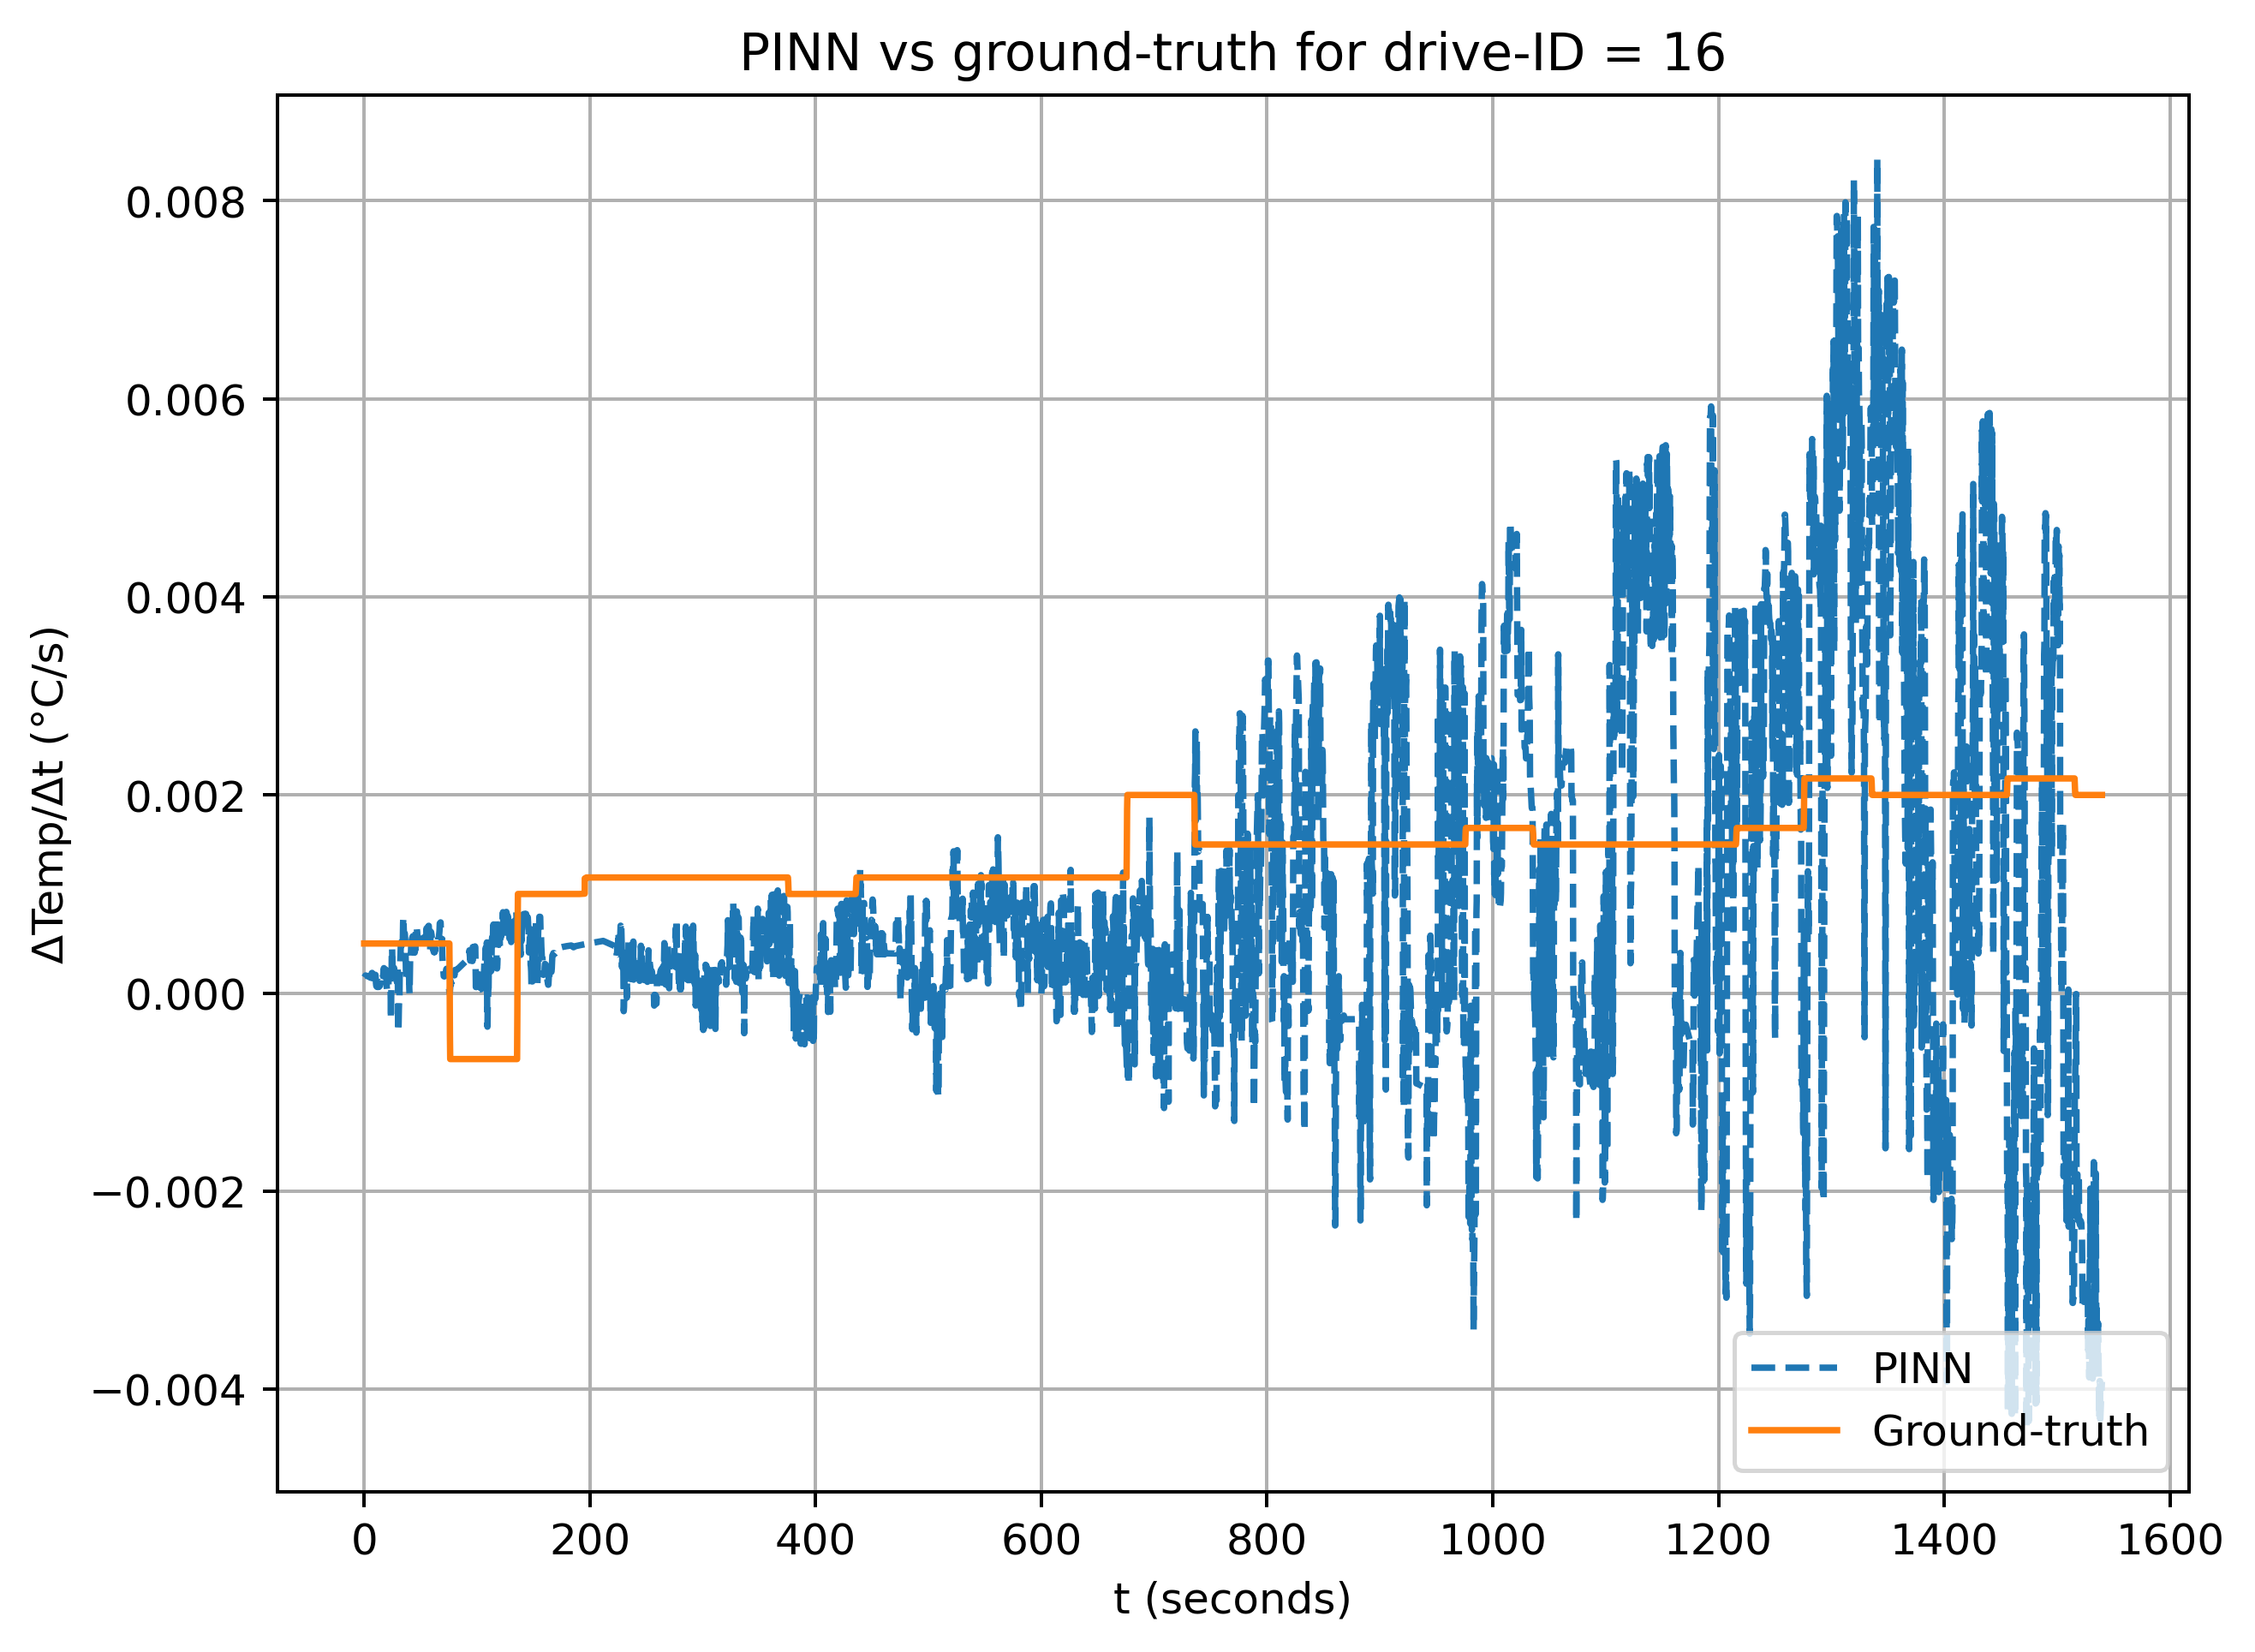

In [25]:
# # Test values = [16,39,47,52,72,81,88] 
bl = True
evaluate(idd=16, bl = bl)

(11259, 10)
time: 0.03027820587158203
MAE: 1.0437852
MSE: 2.541211
Relative error (%): 6.946496665477753


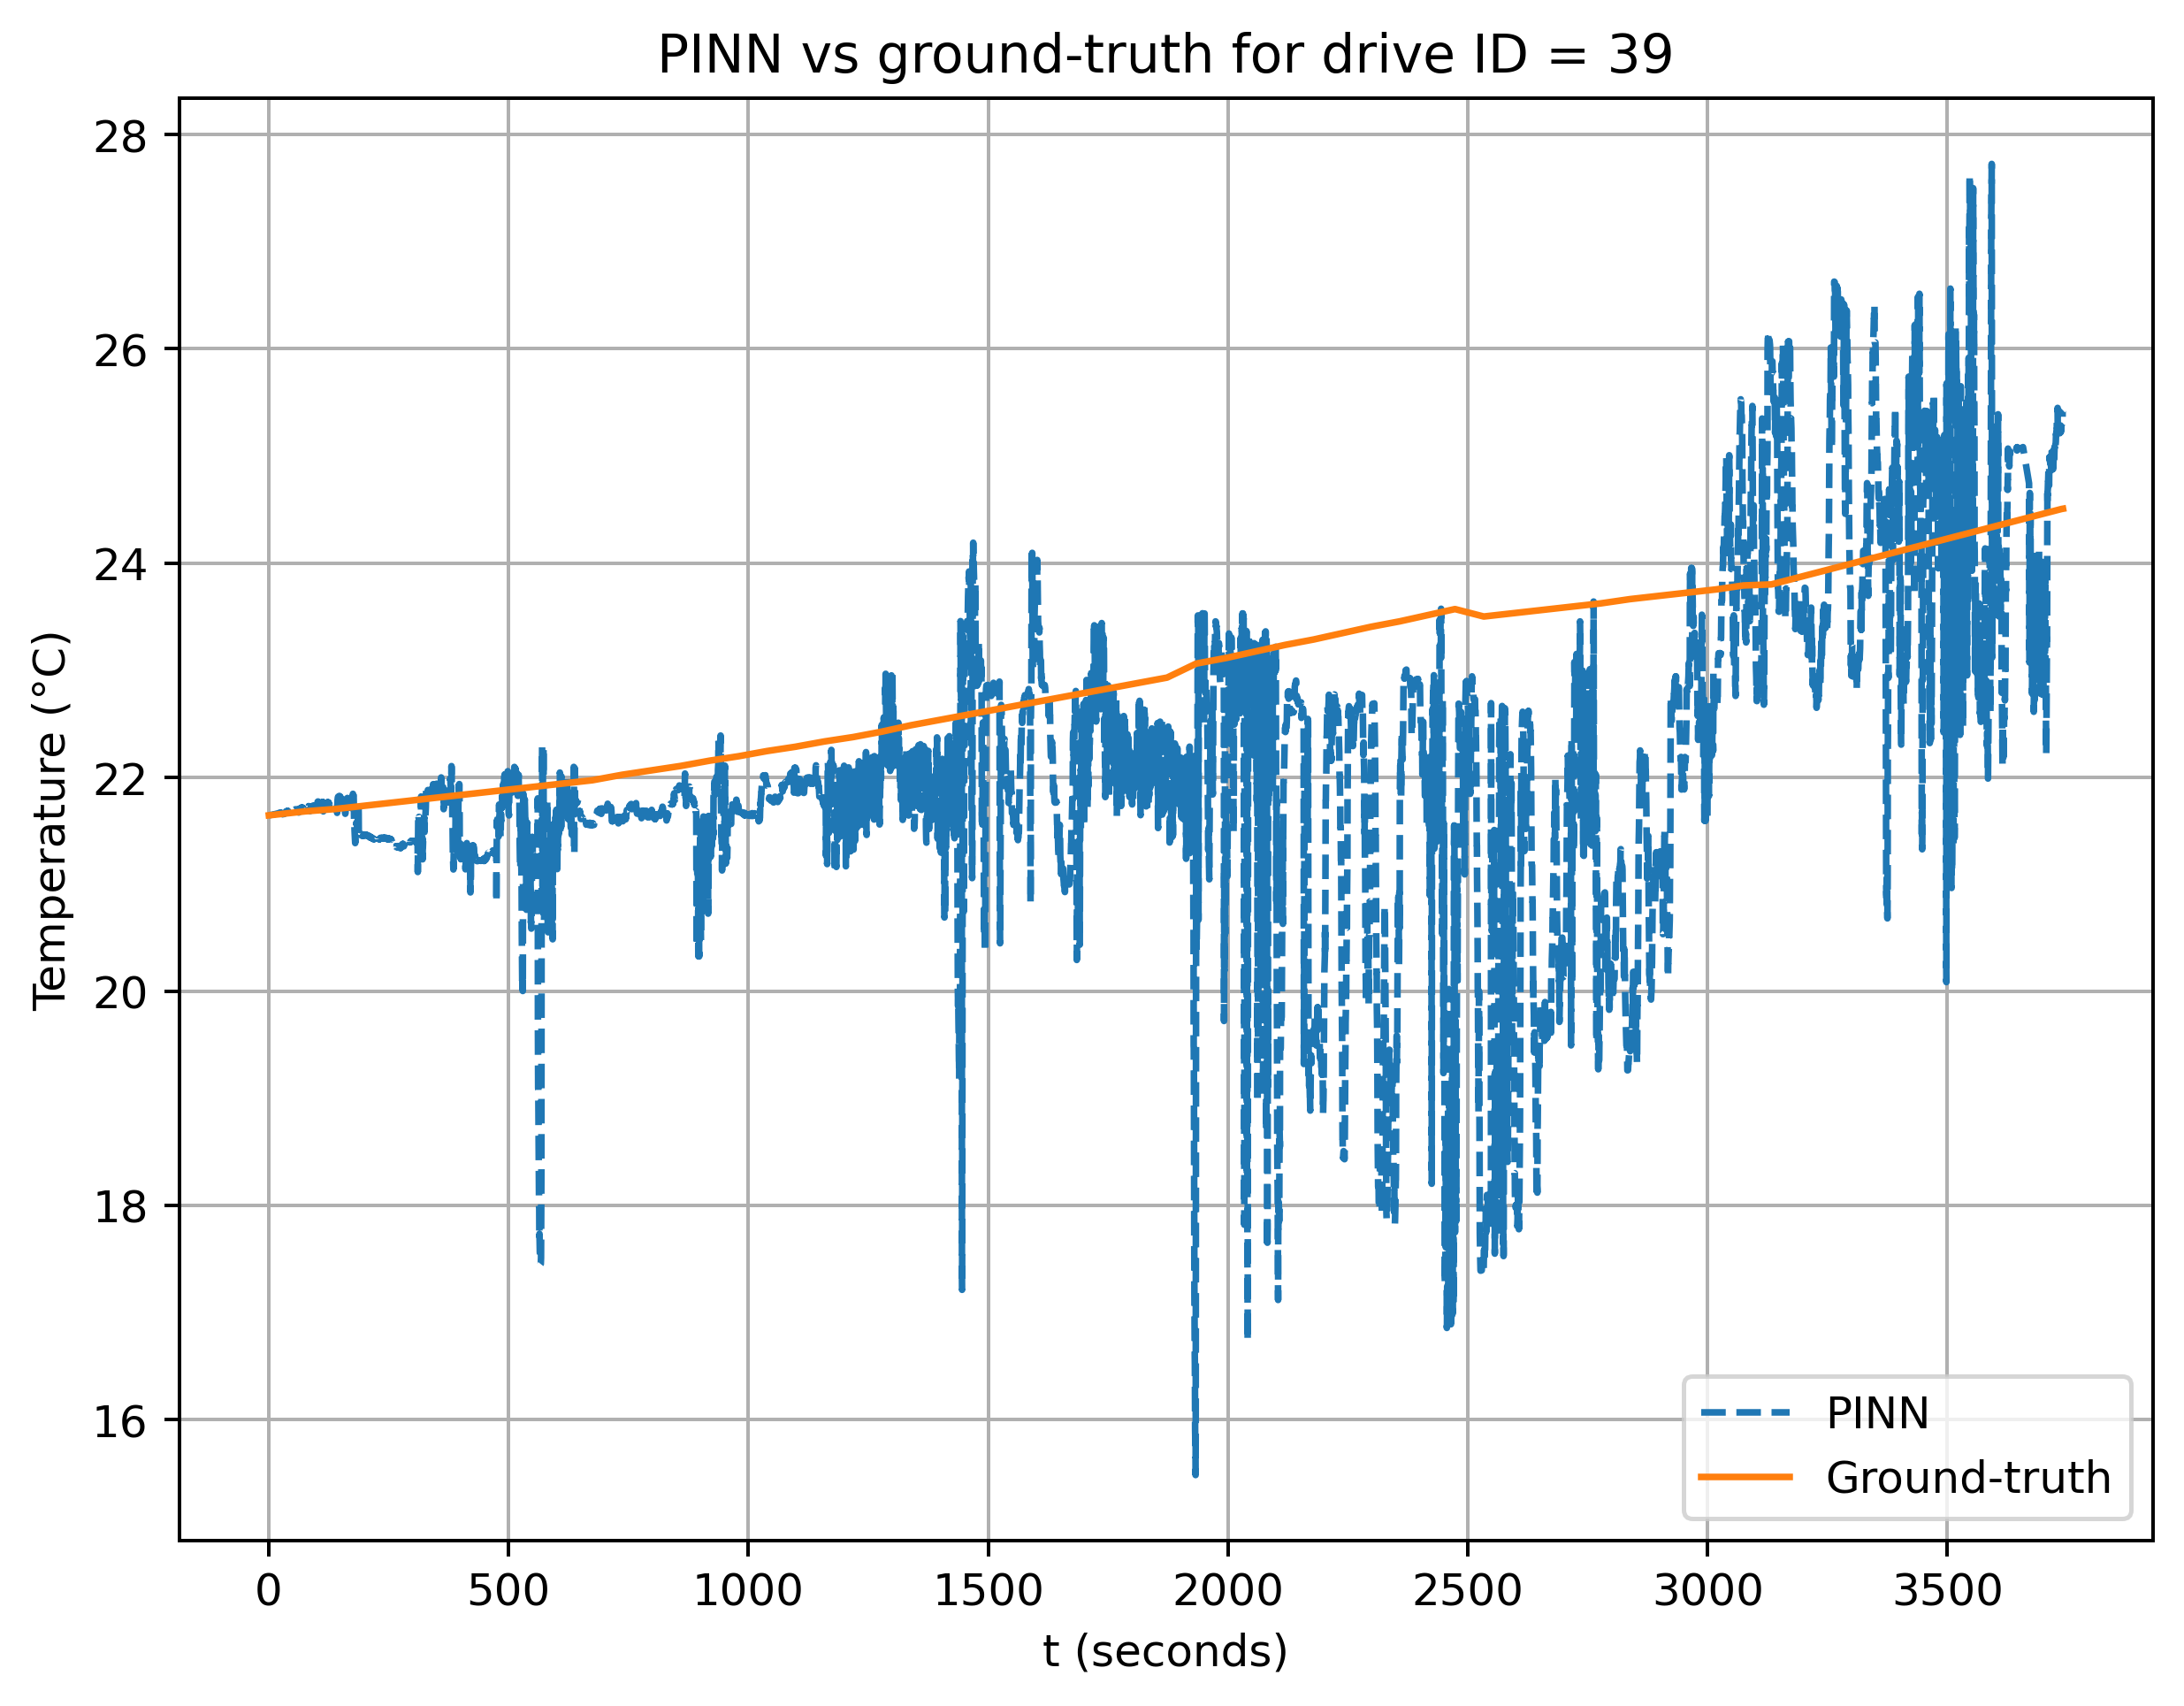

time: 0.04437851905822754
MAE: 0.0015945943
MSE: 5.9806716e-06
Relative error (%): 280.58621883392334


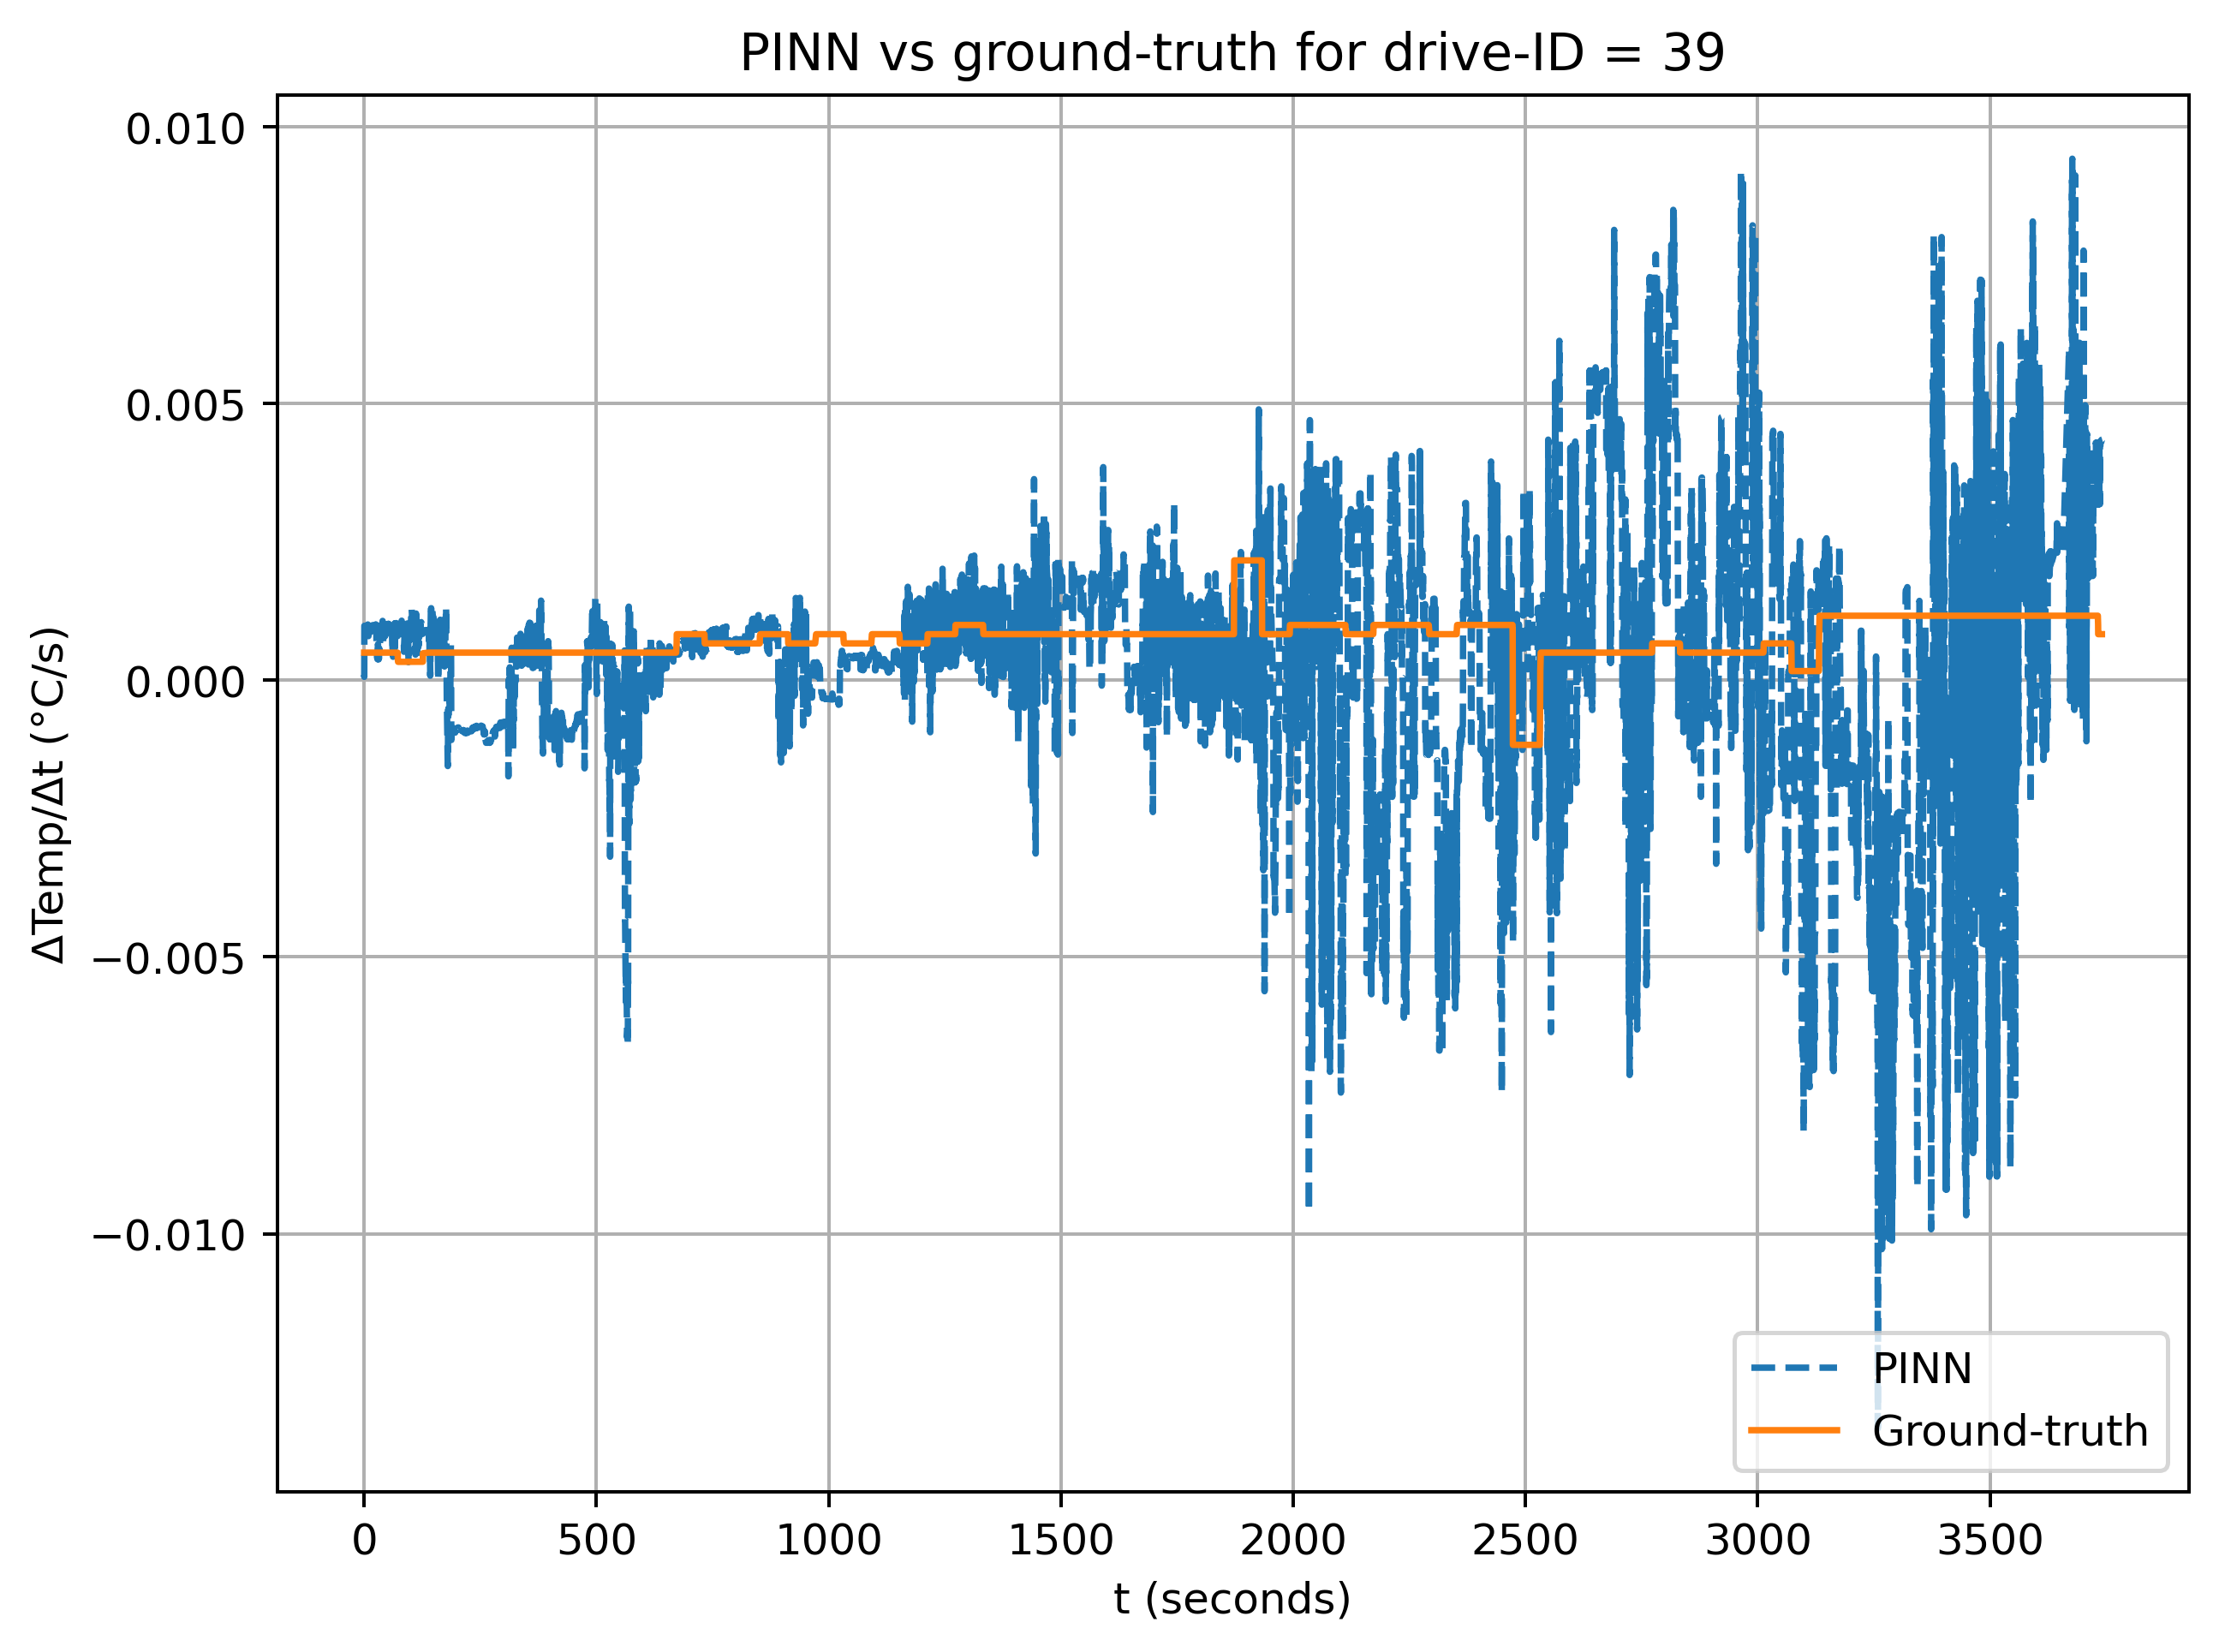

In [26]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=39, bl = bl)

(2440, 10)
time: 0.009217023849487305
MAE: 0.12457969
MSE: 0.024729967
Relative error (%): 0.4973308648914099


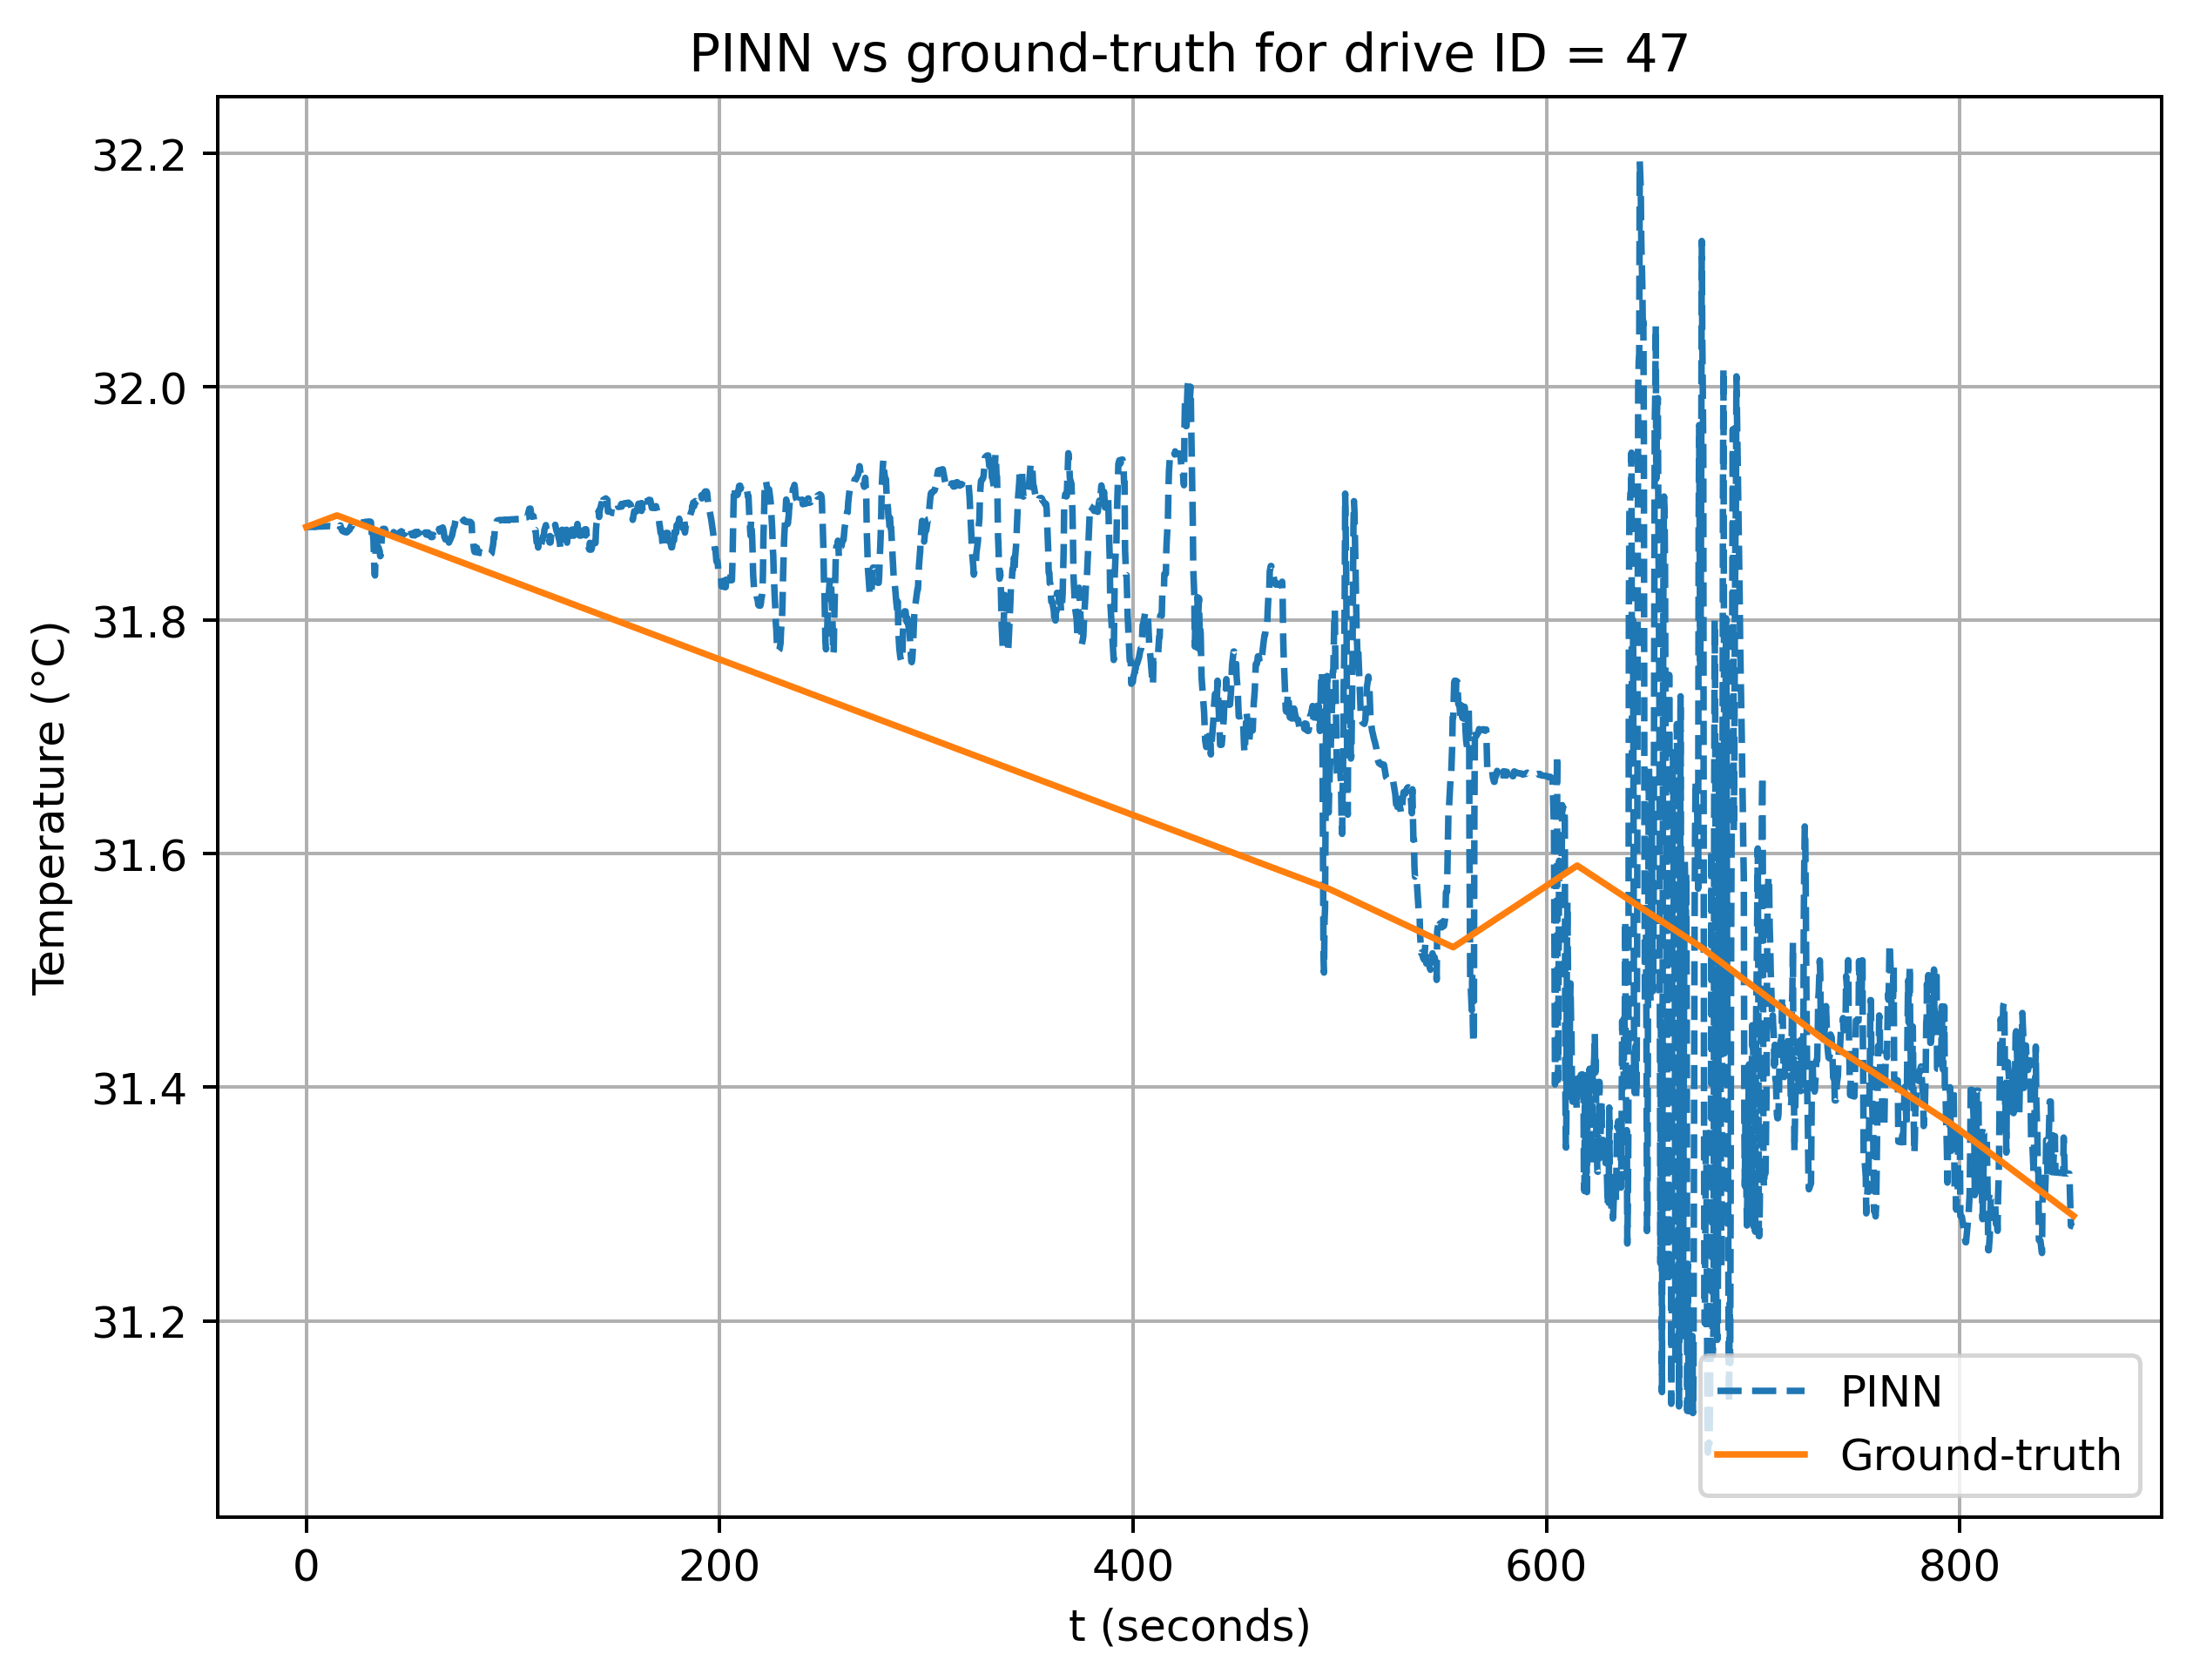

time: 0.011341094970703125
MAE: 0.0008661694
MSE: 8.863447e-07
Relative error (%): 100.09297132492065


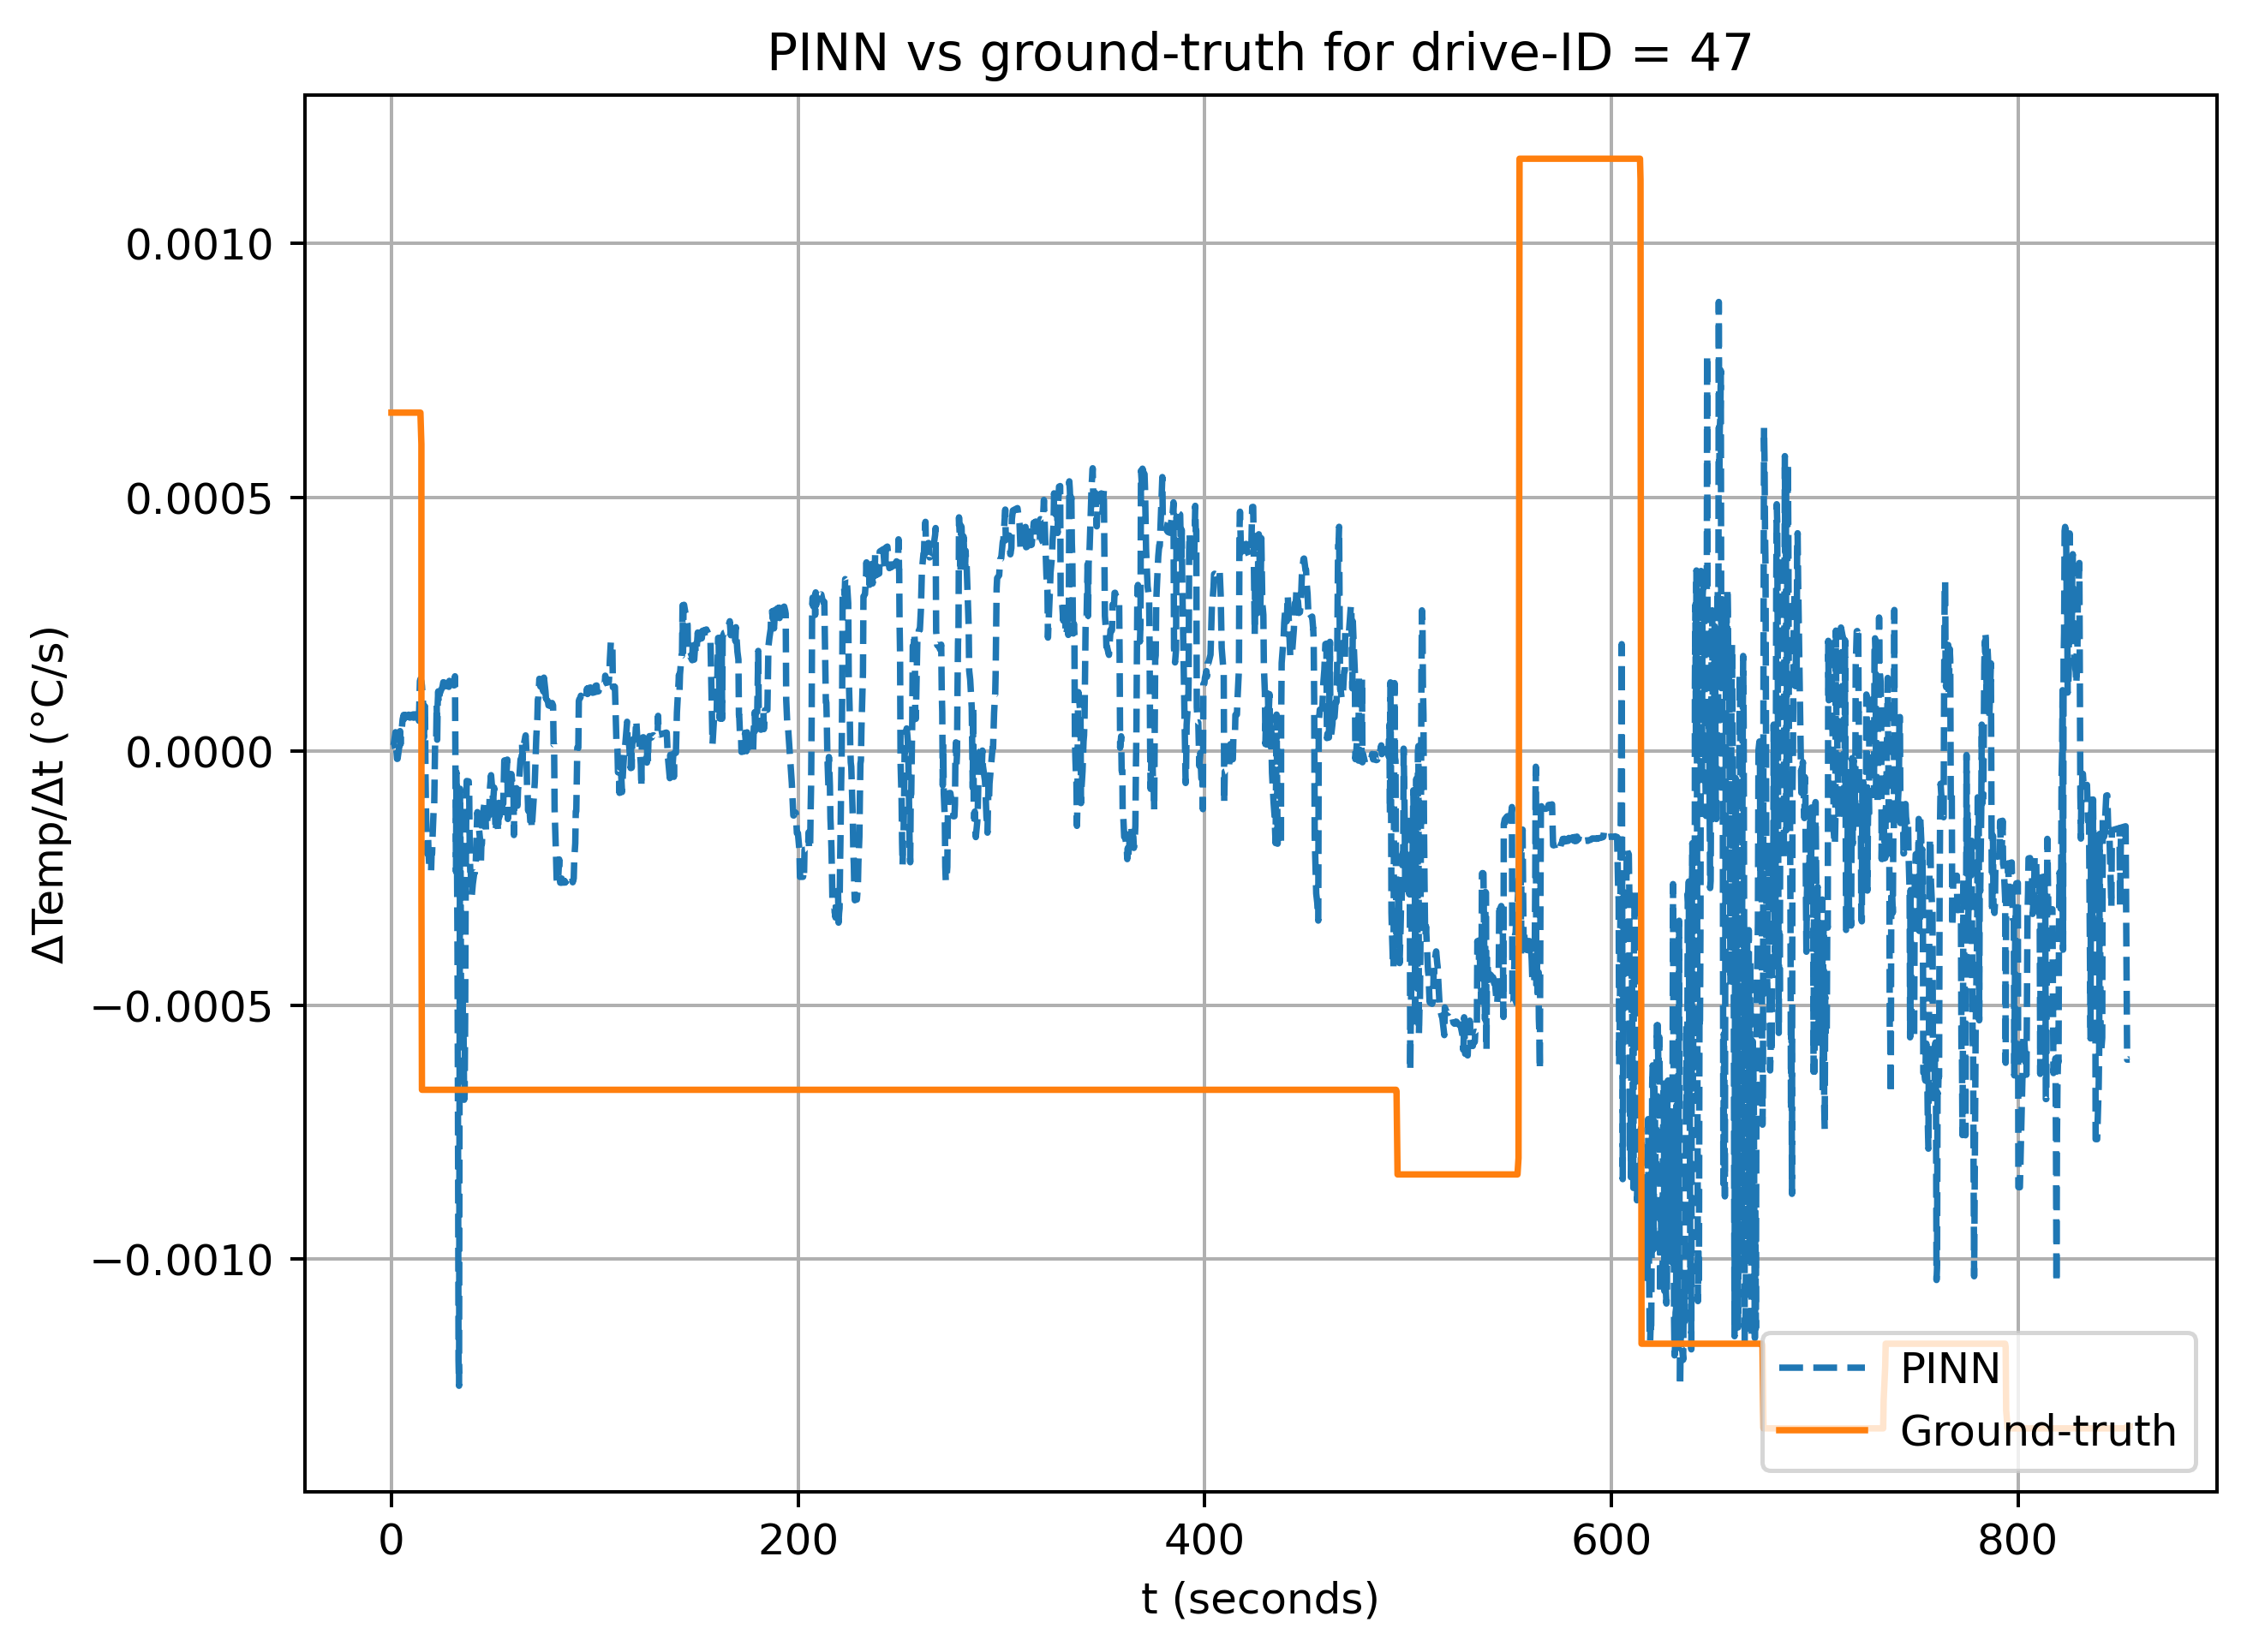

In [27]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=47, bl = bl)

(12741, 10)
time: 0.04990386962890625
MAE: 0.60780066
MSE: 0.6633239
Relative error (%): 3.921656310558319


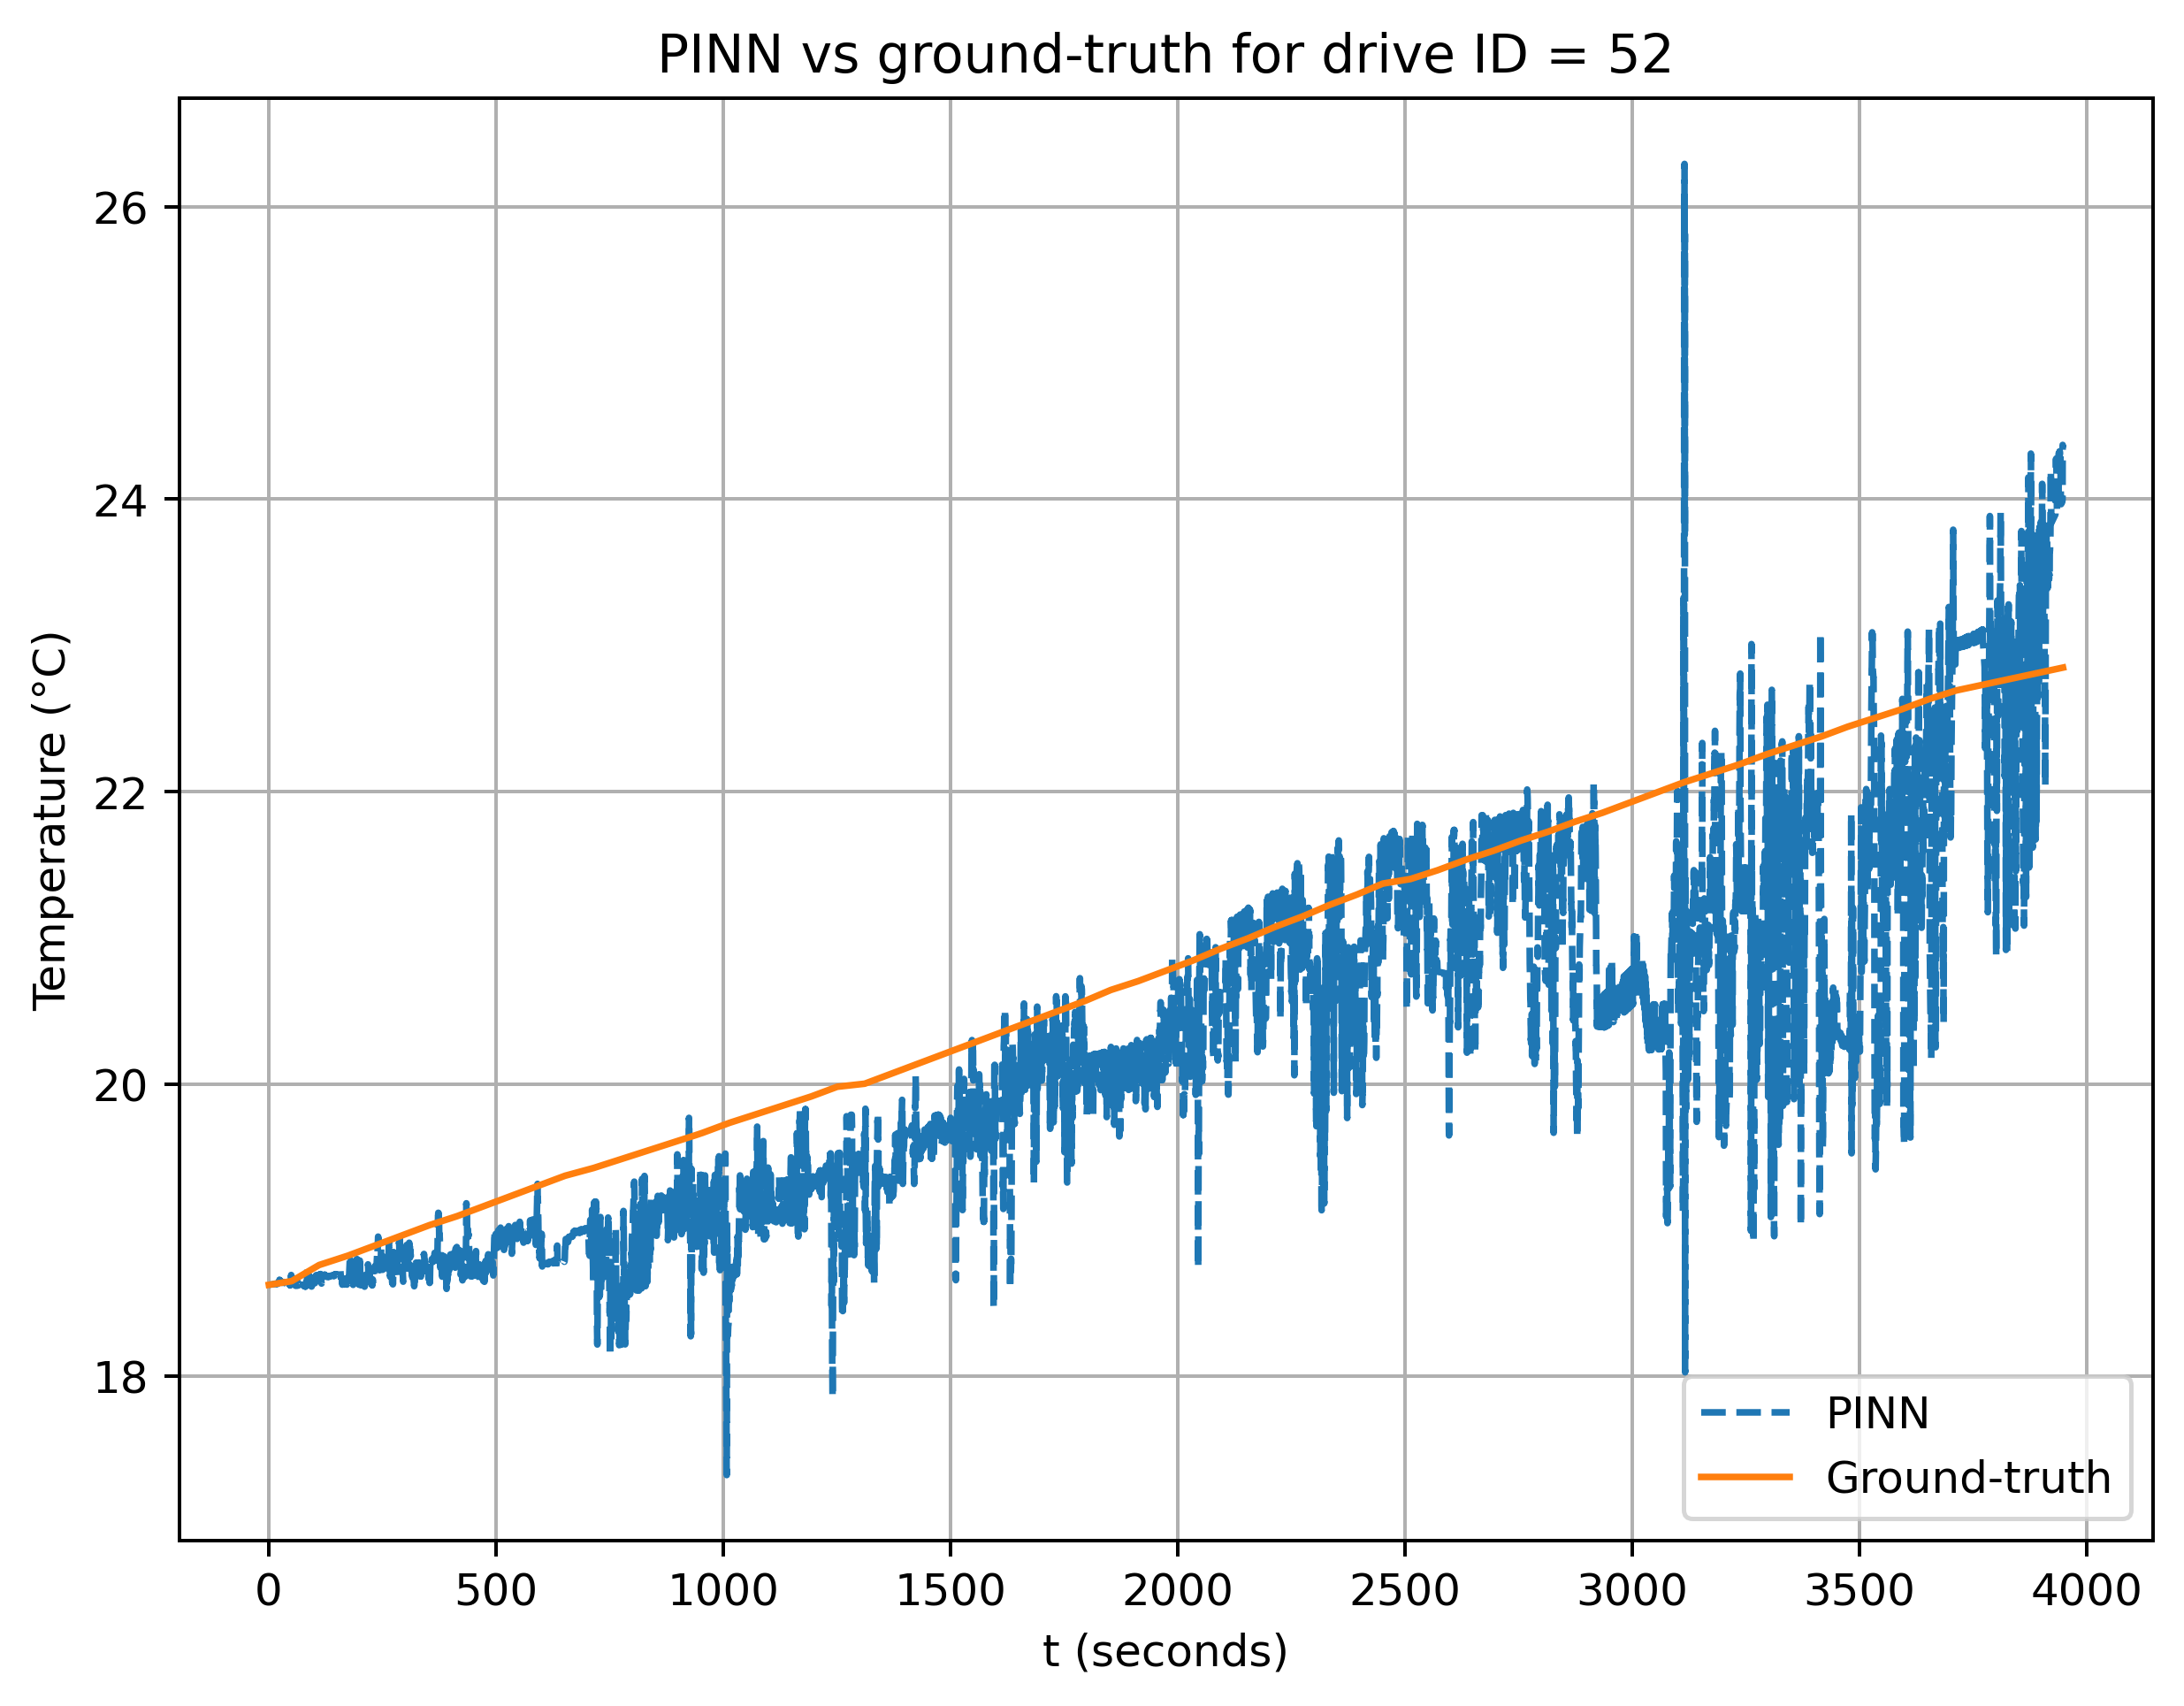

time: 0.051497459411621094
MAE: 0.0009050404
MSE: 1.5453624e-06
Relative error (%): 113.51258754730225


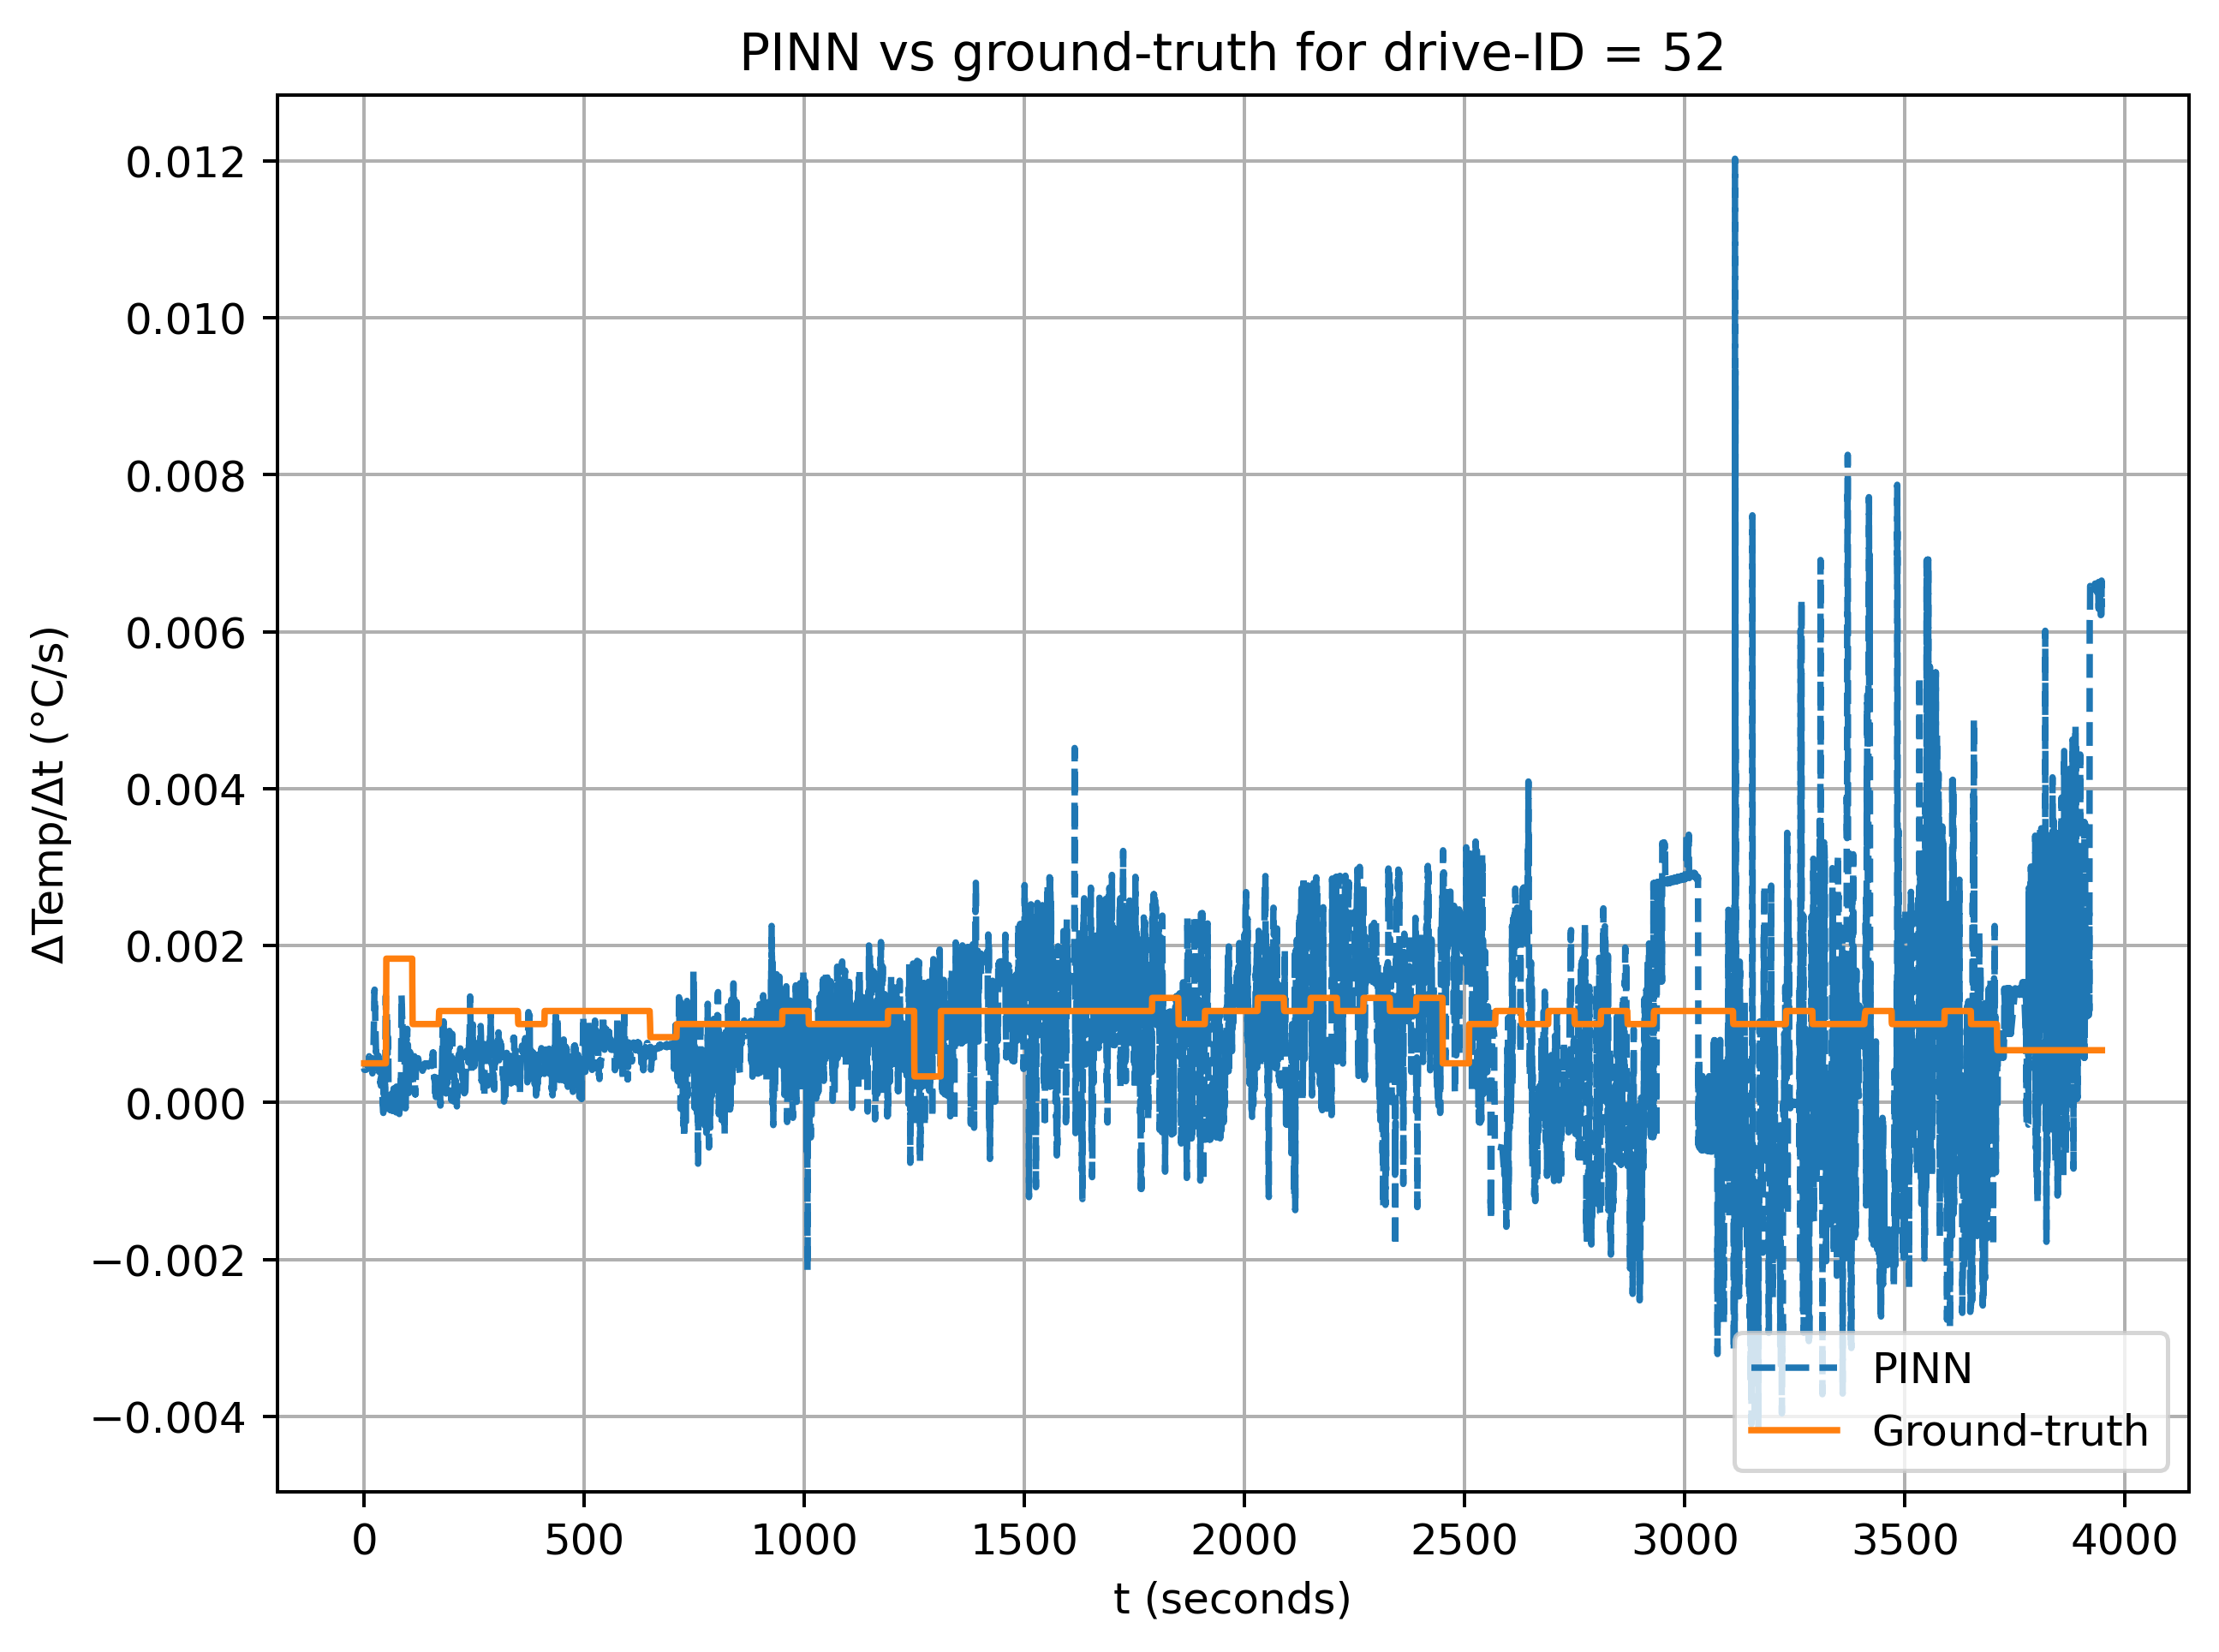

In [28]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=52, bl = bl)

(20002, 10)
time: 0.05657076835632324
MAE: 2.8460982
MSE: 19.618643
Relative error (%): 25.773704051971436


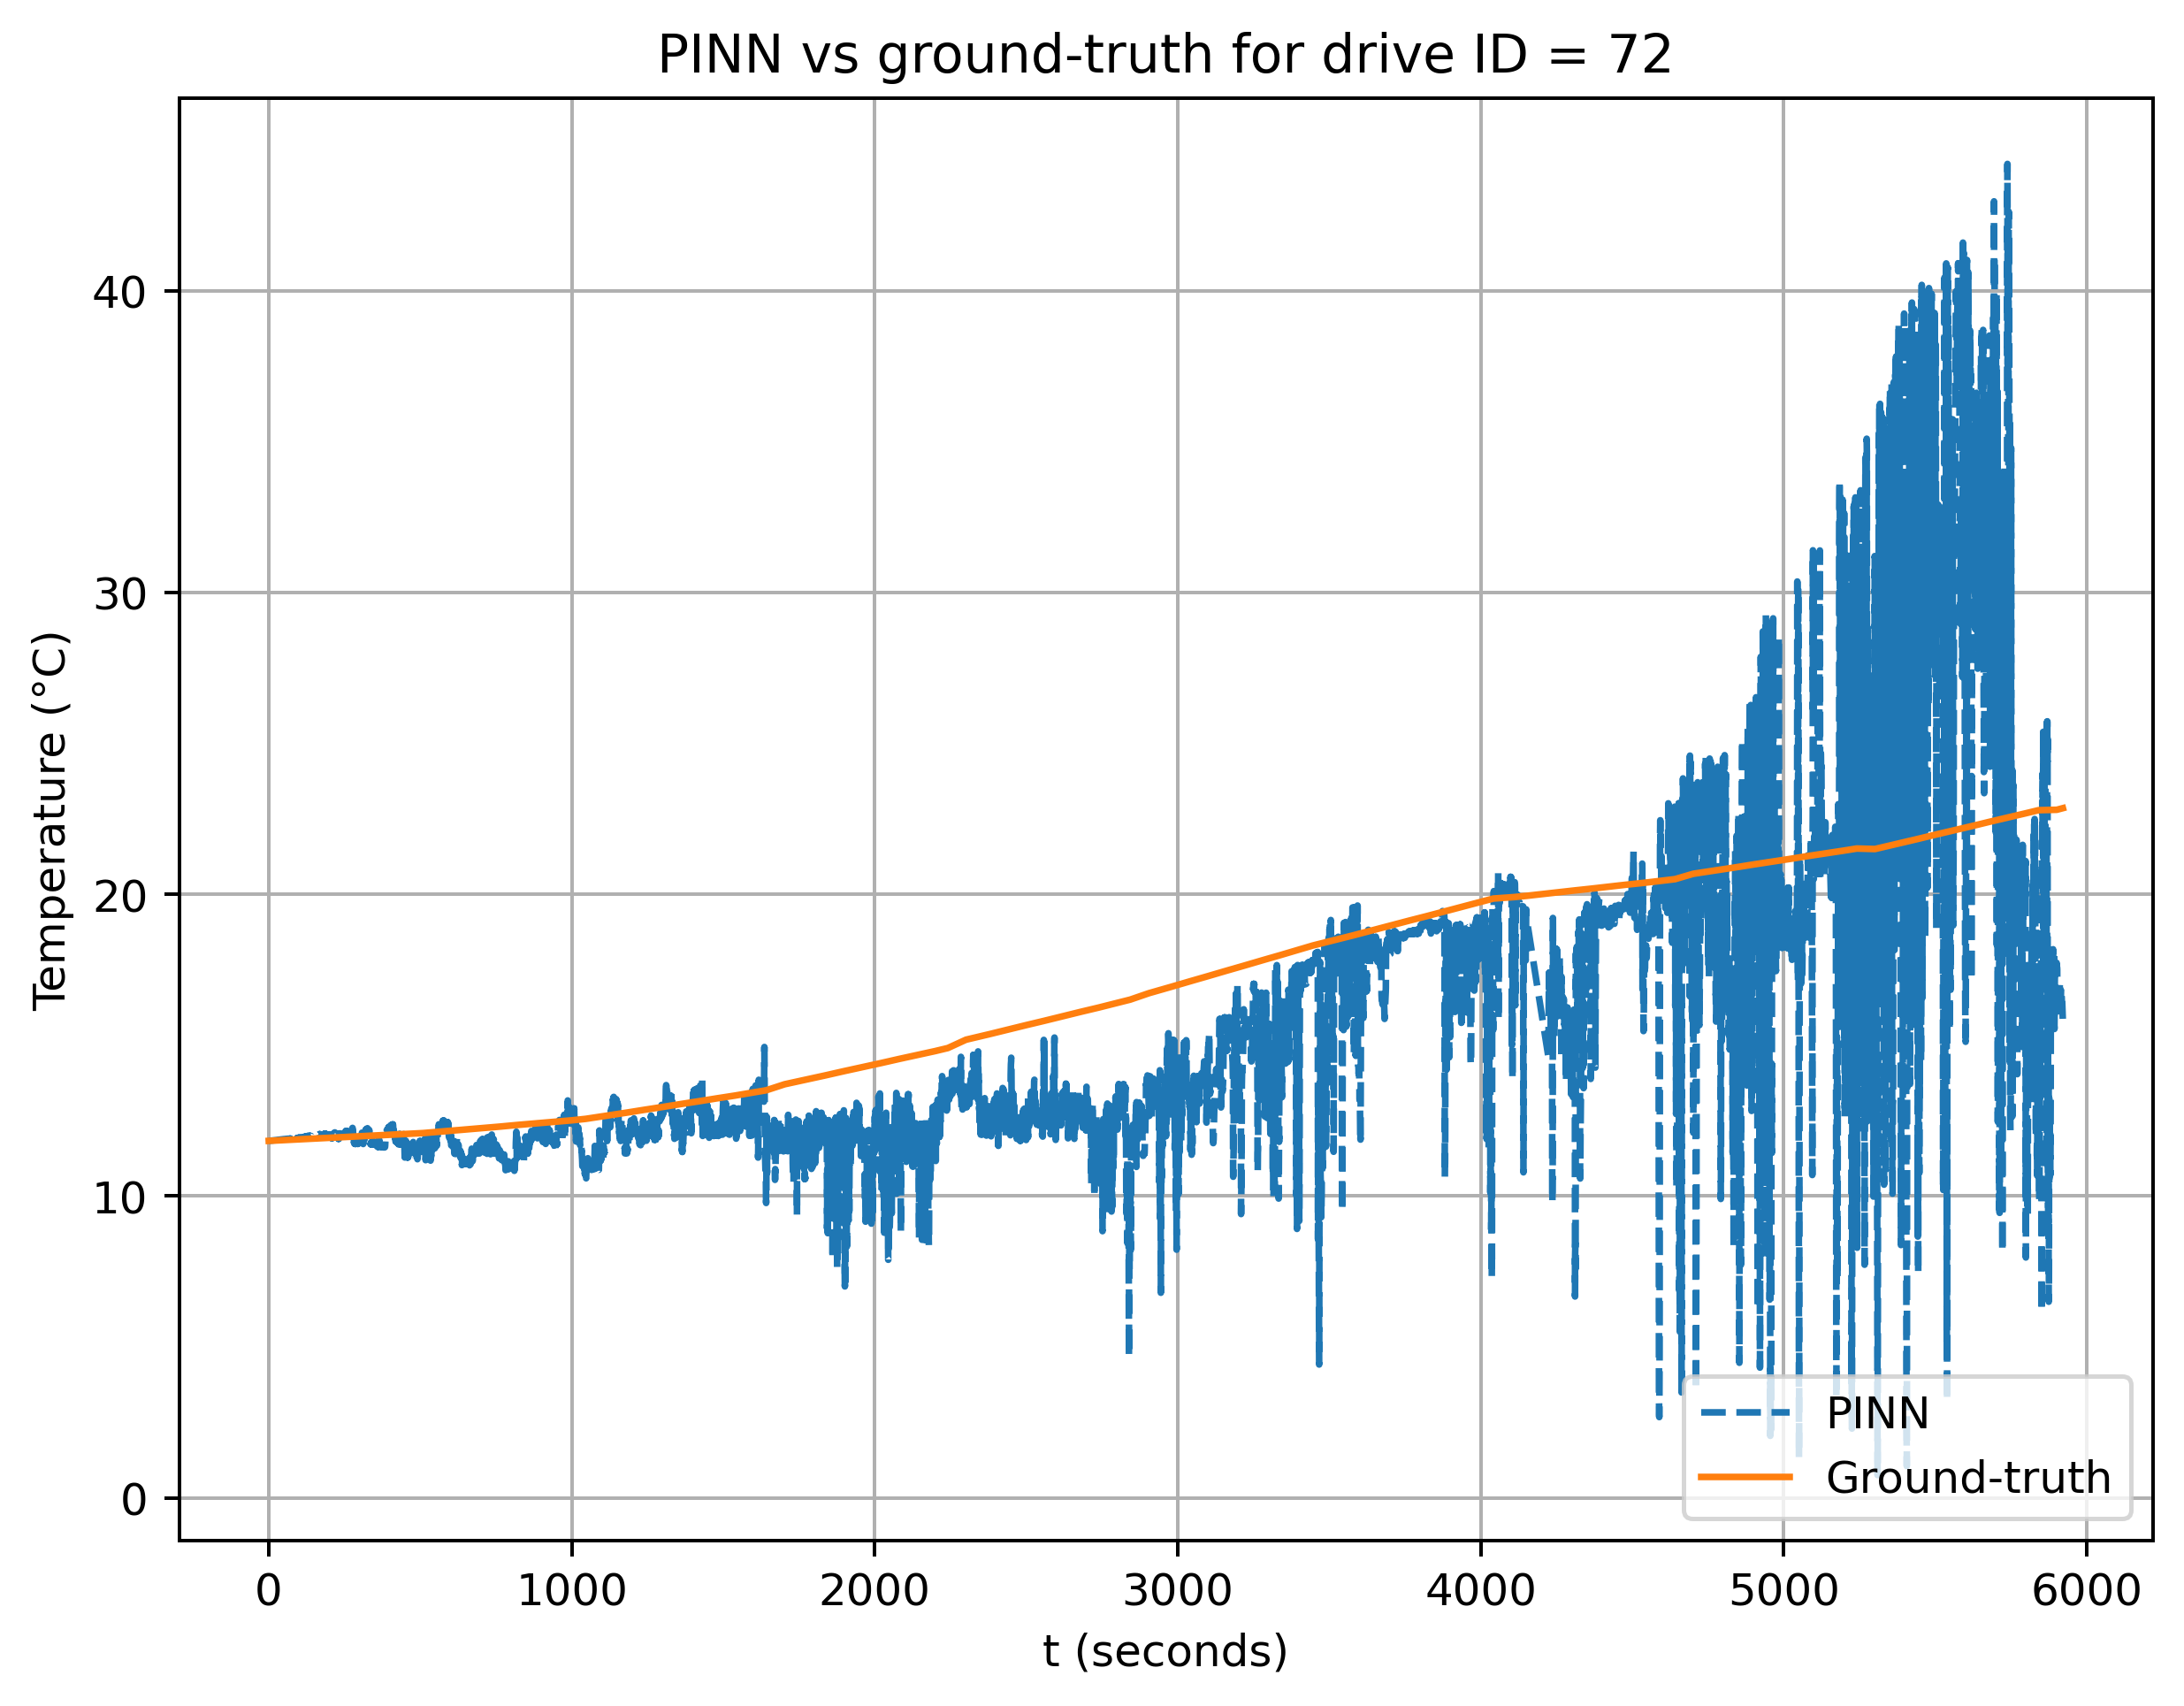

time: 0.08362245559692383
MAE: 0.0033802676
MSE: 2.7862137e-05
Relative error (%): 254.76770401000977


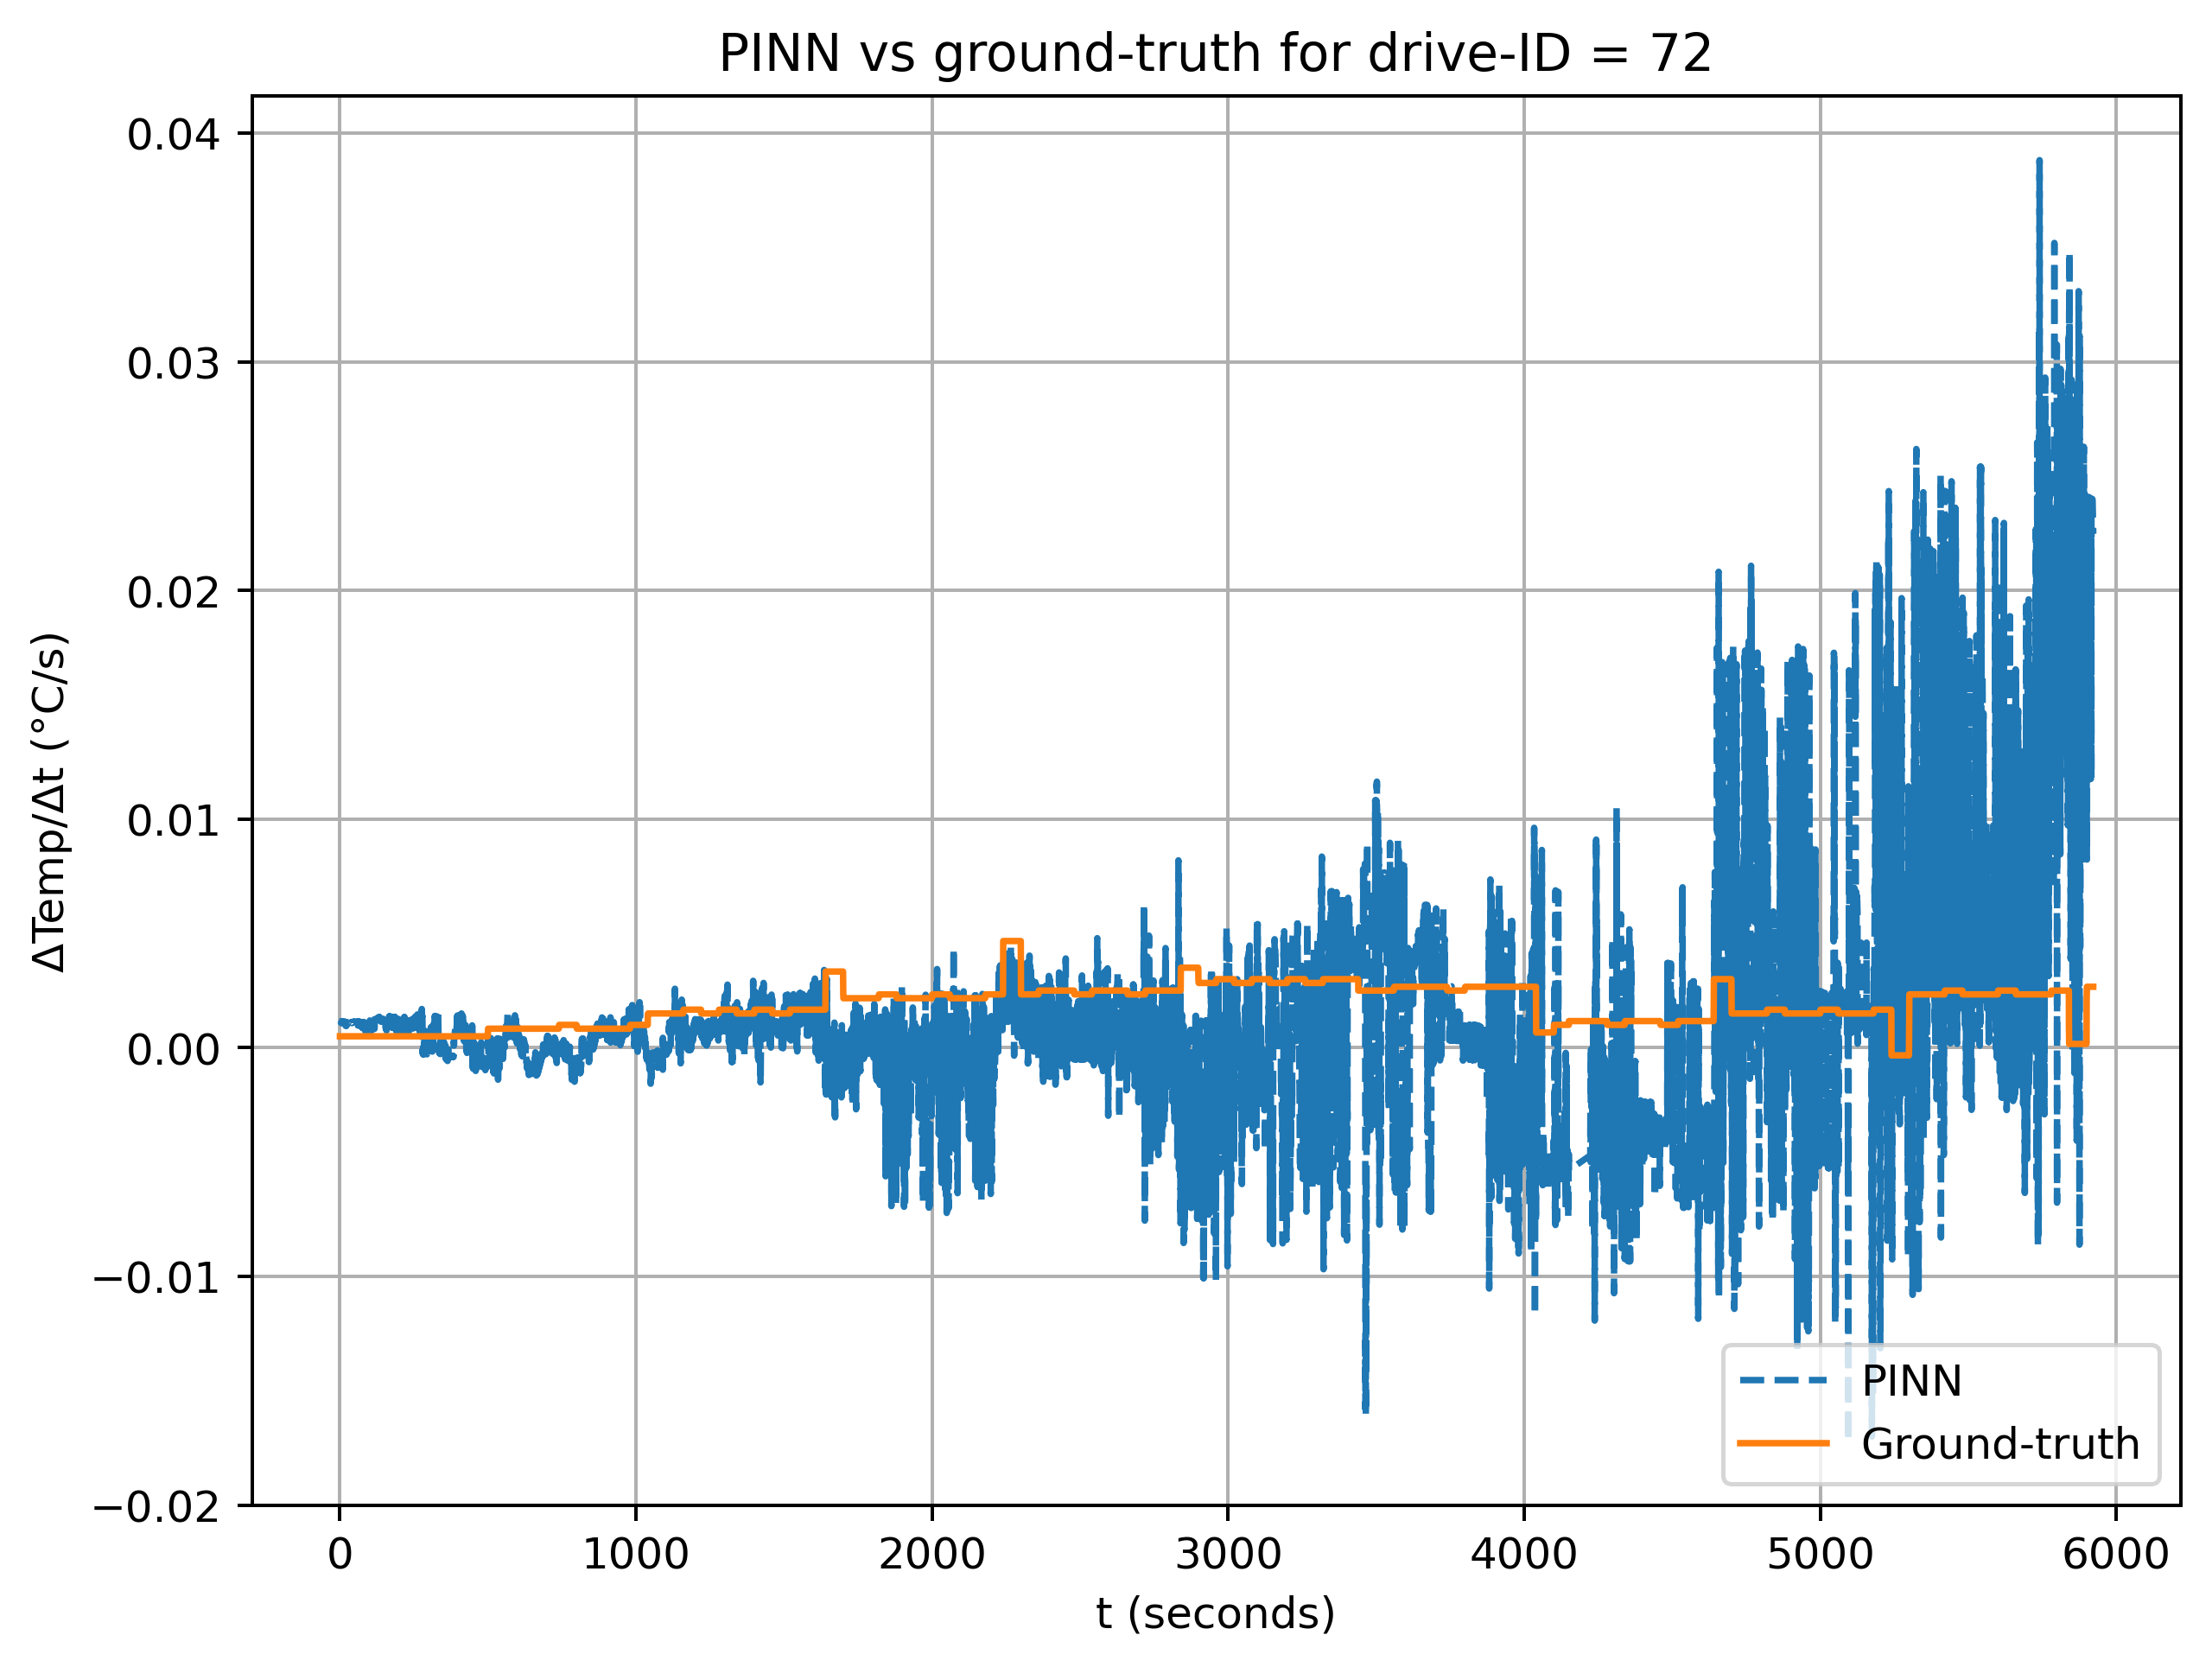

In [29]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=72, bl = bl)

(18267, 10)
time: 0.05000901222229004
MAE: 2.3759527
MSE: 10.798246
Relative error (%): 11.43597885966301


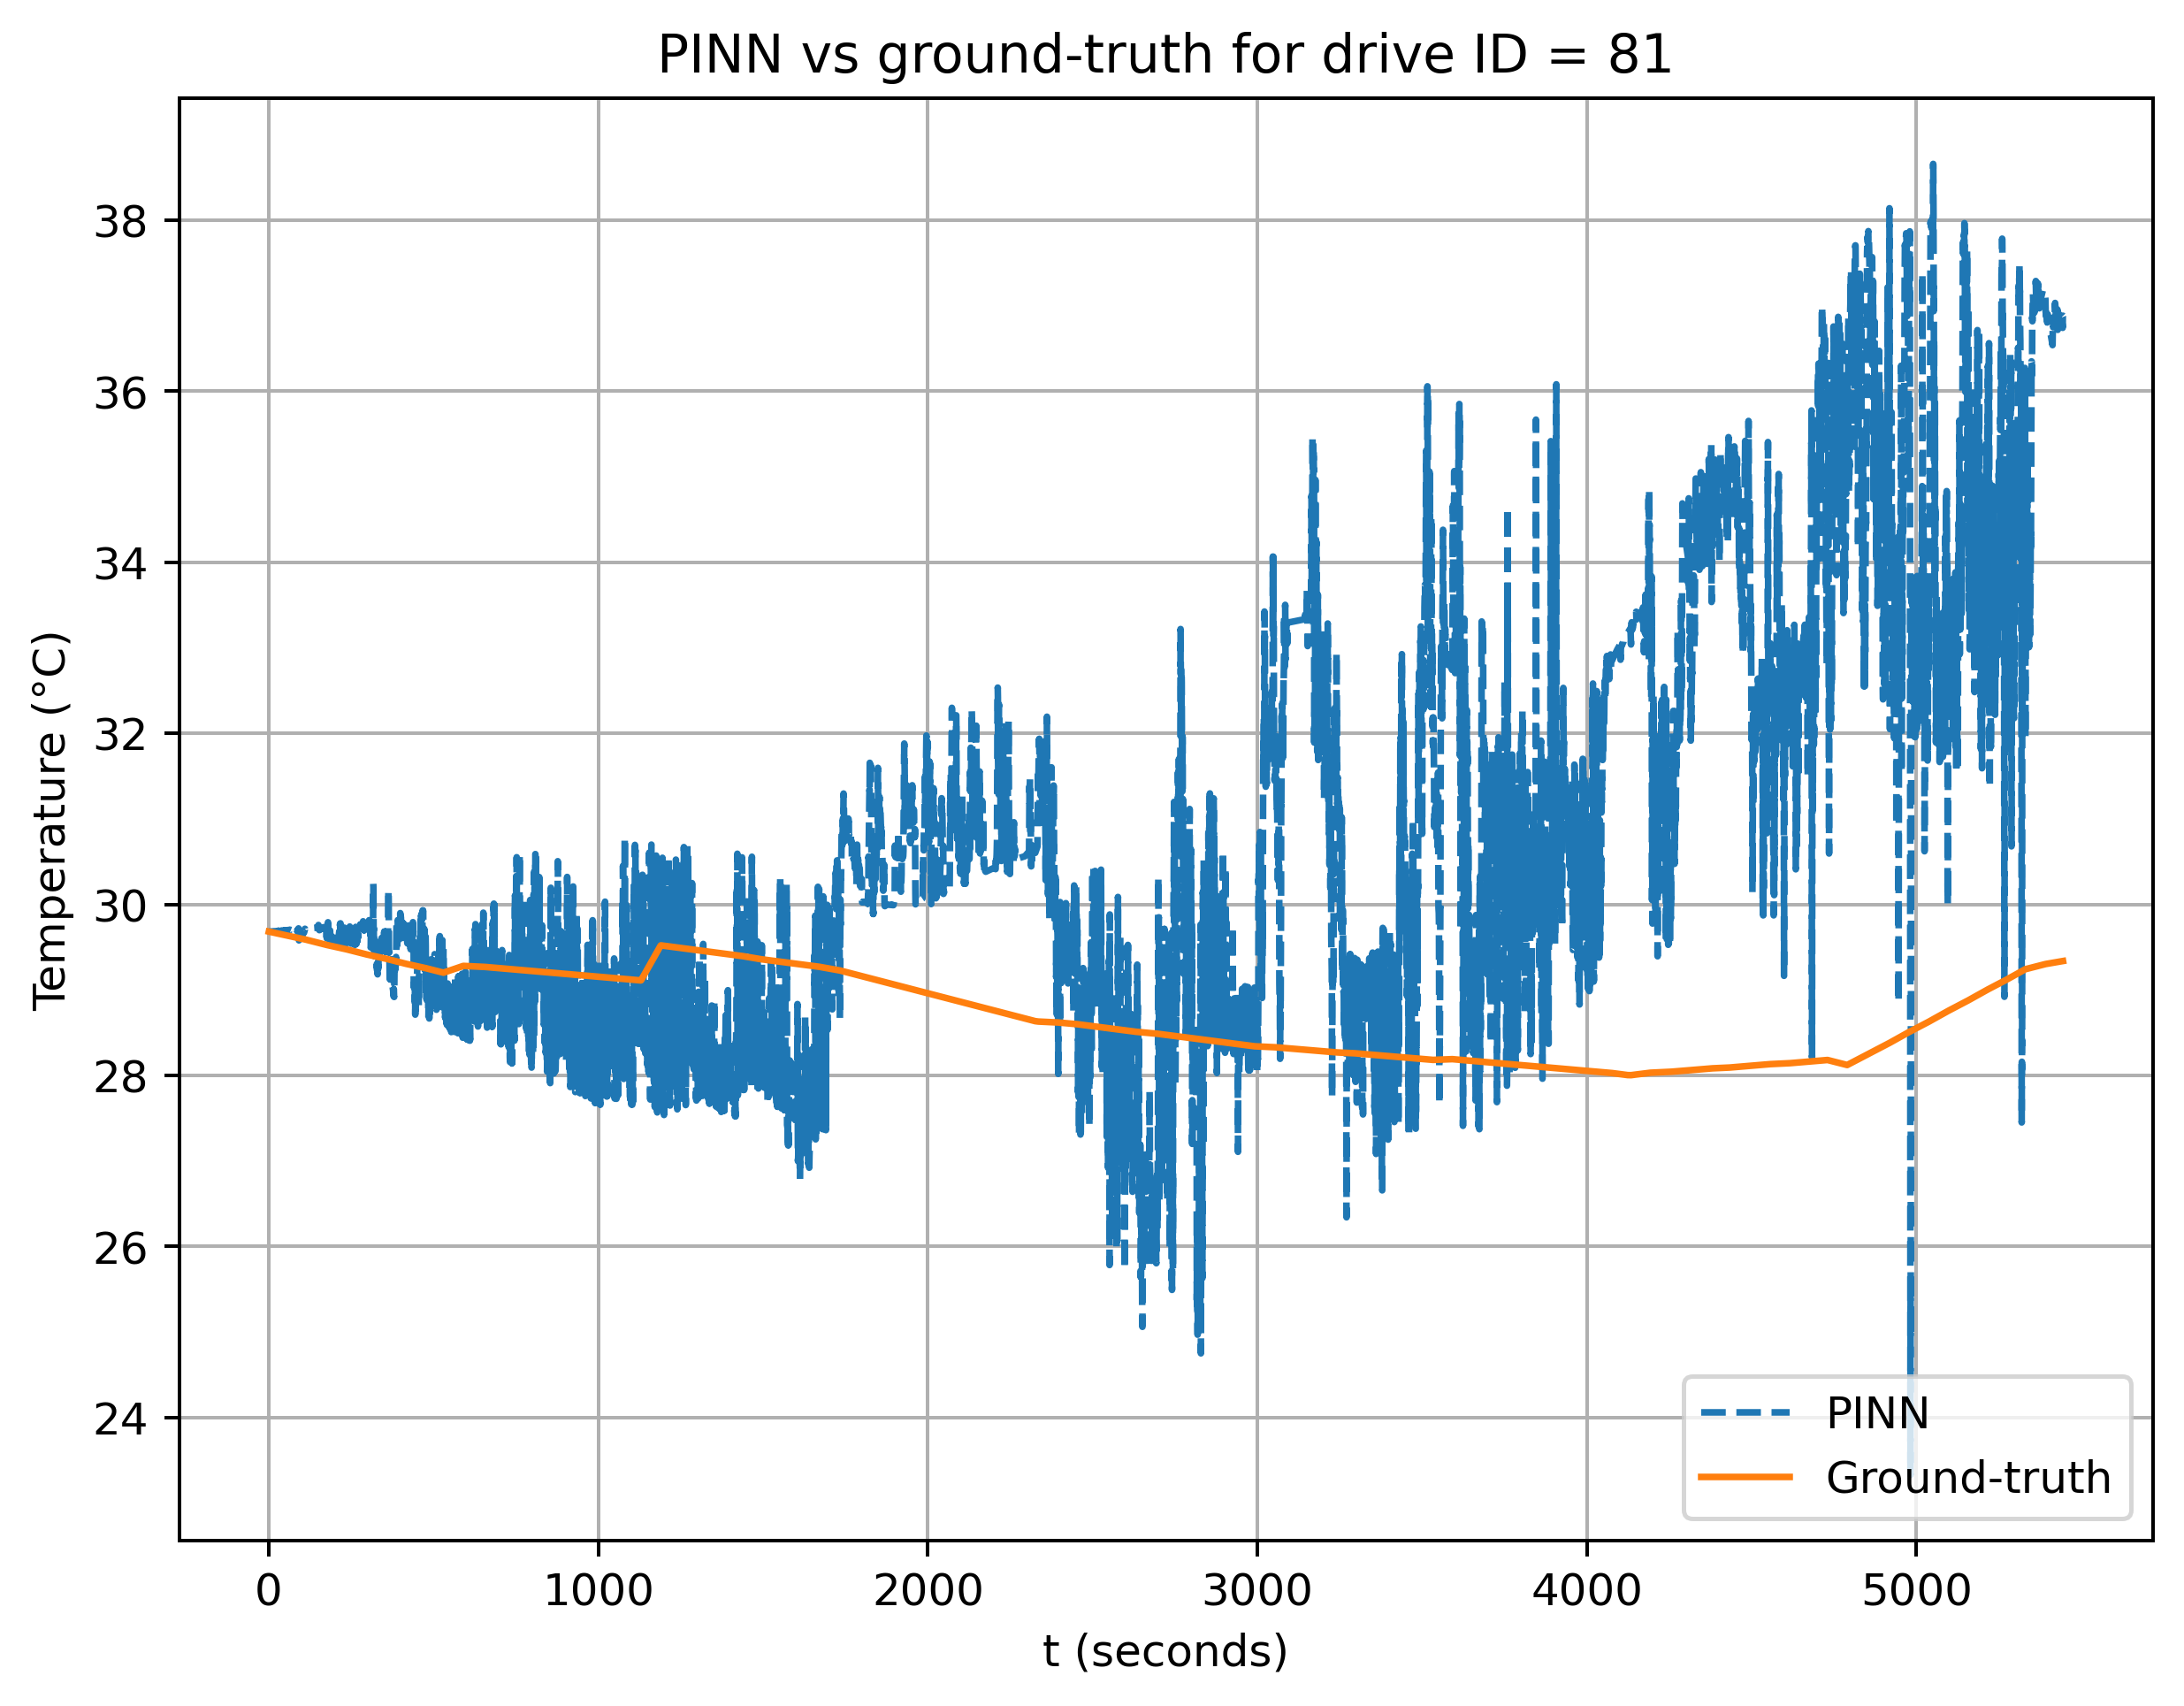

time: 0.07424068450927734
MAE: 0.0021092168
MSE: 8.340508e-06
Relative error (%): 247.1160650253296


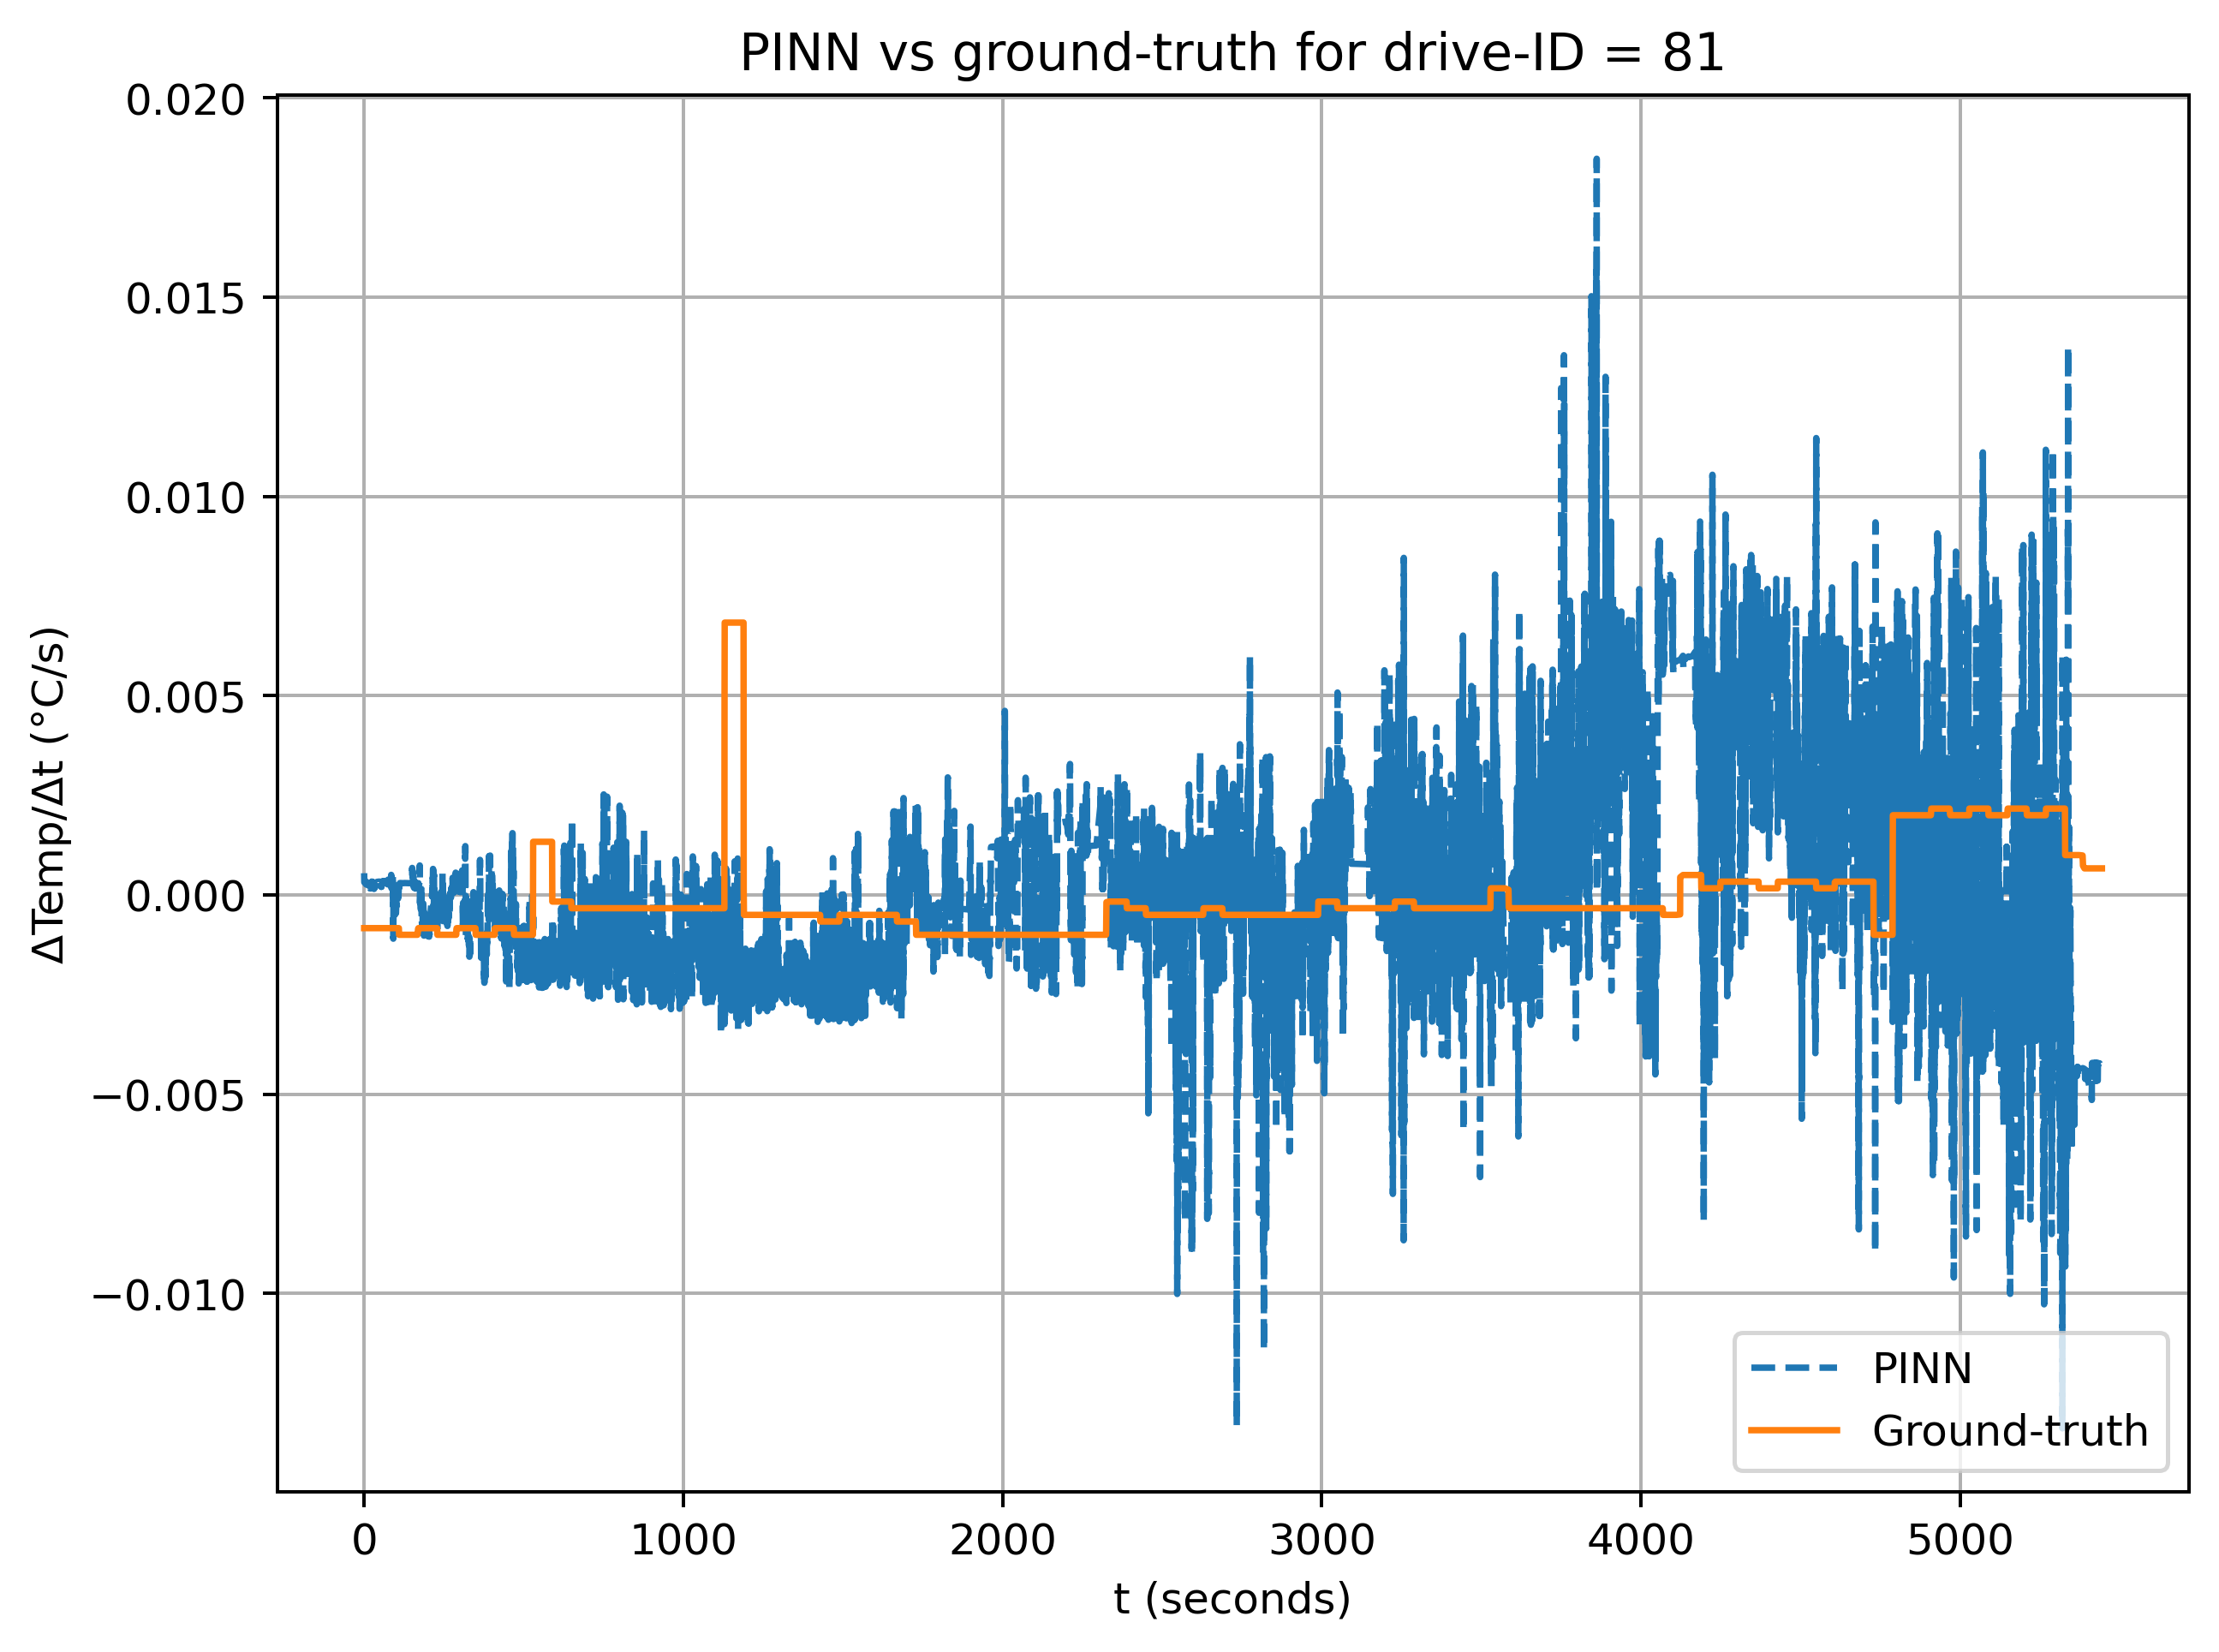

In [30]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=81, bl = bl)

(19418, 10)
time: 0.05550265312194824
MAE: 1.5495552
MSE: 5.513189
Relative error (%): 7.013300061225891


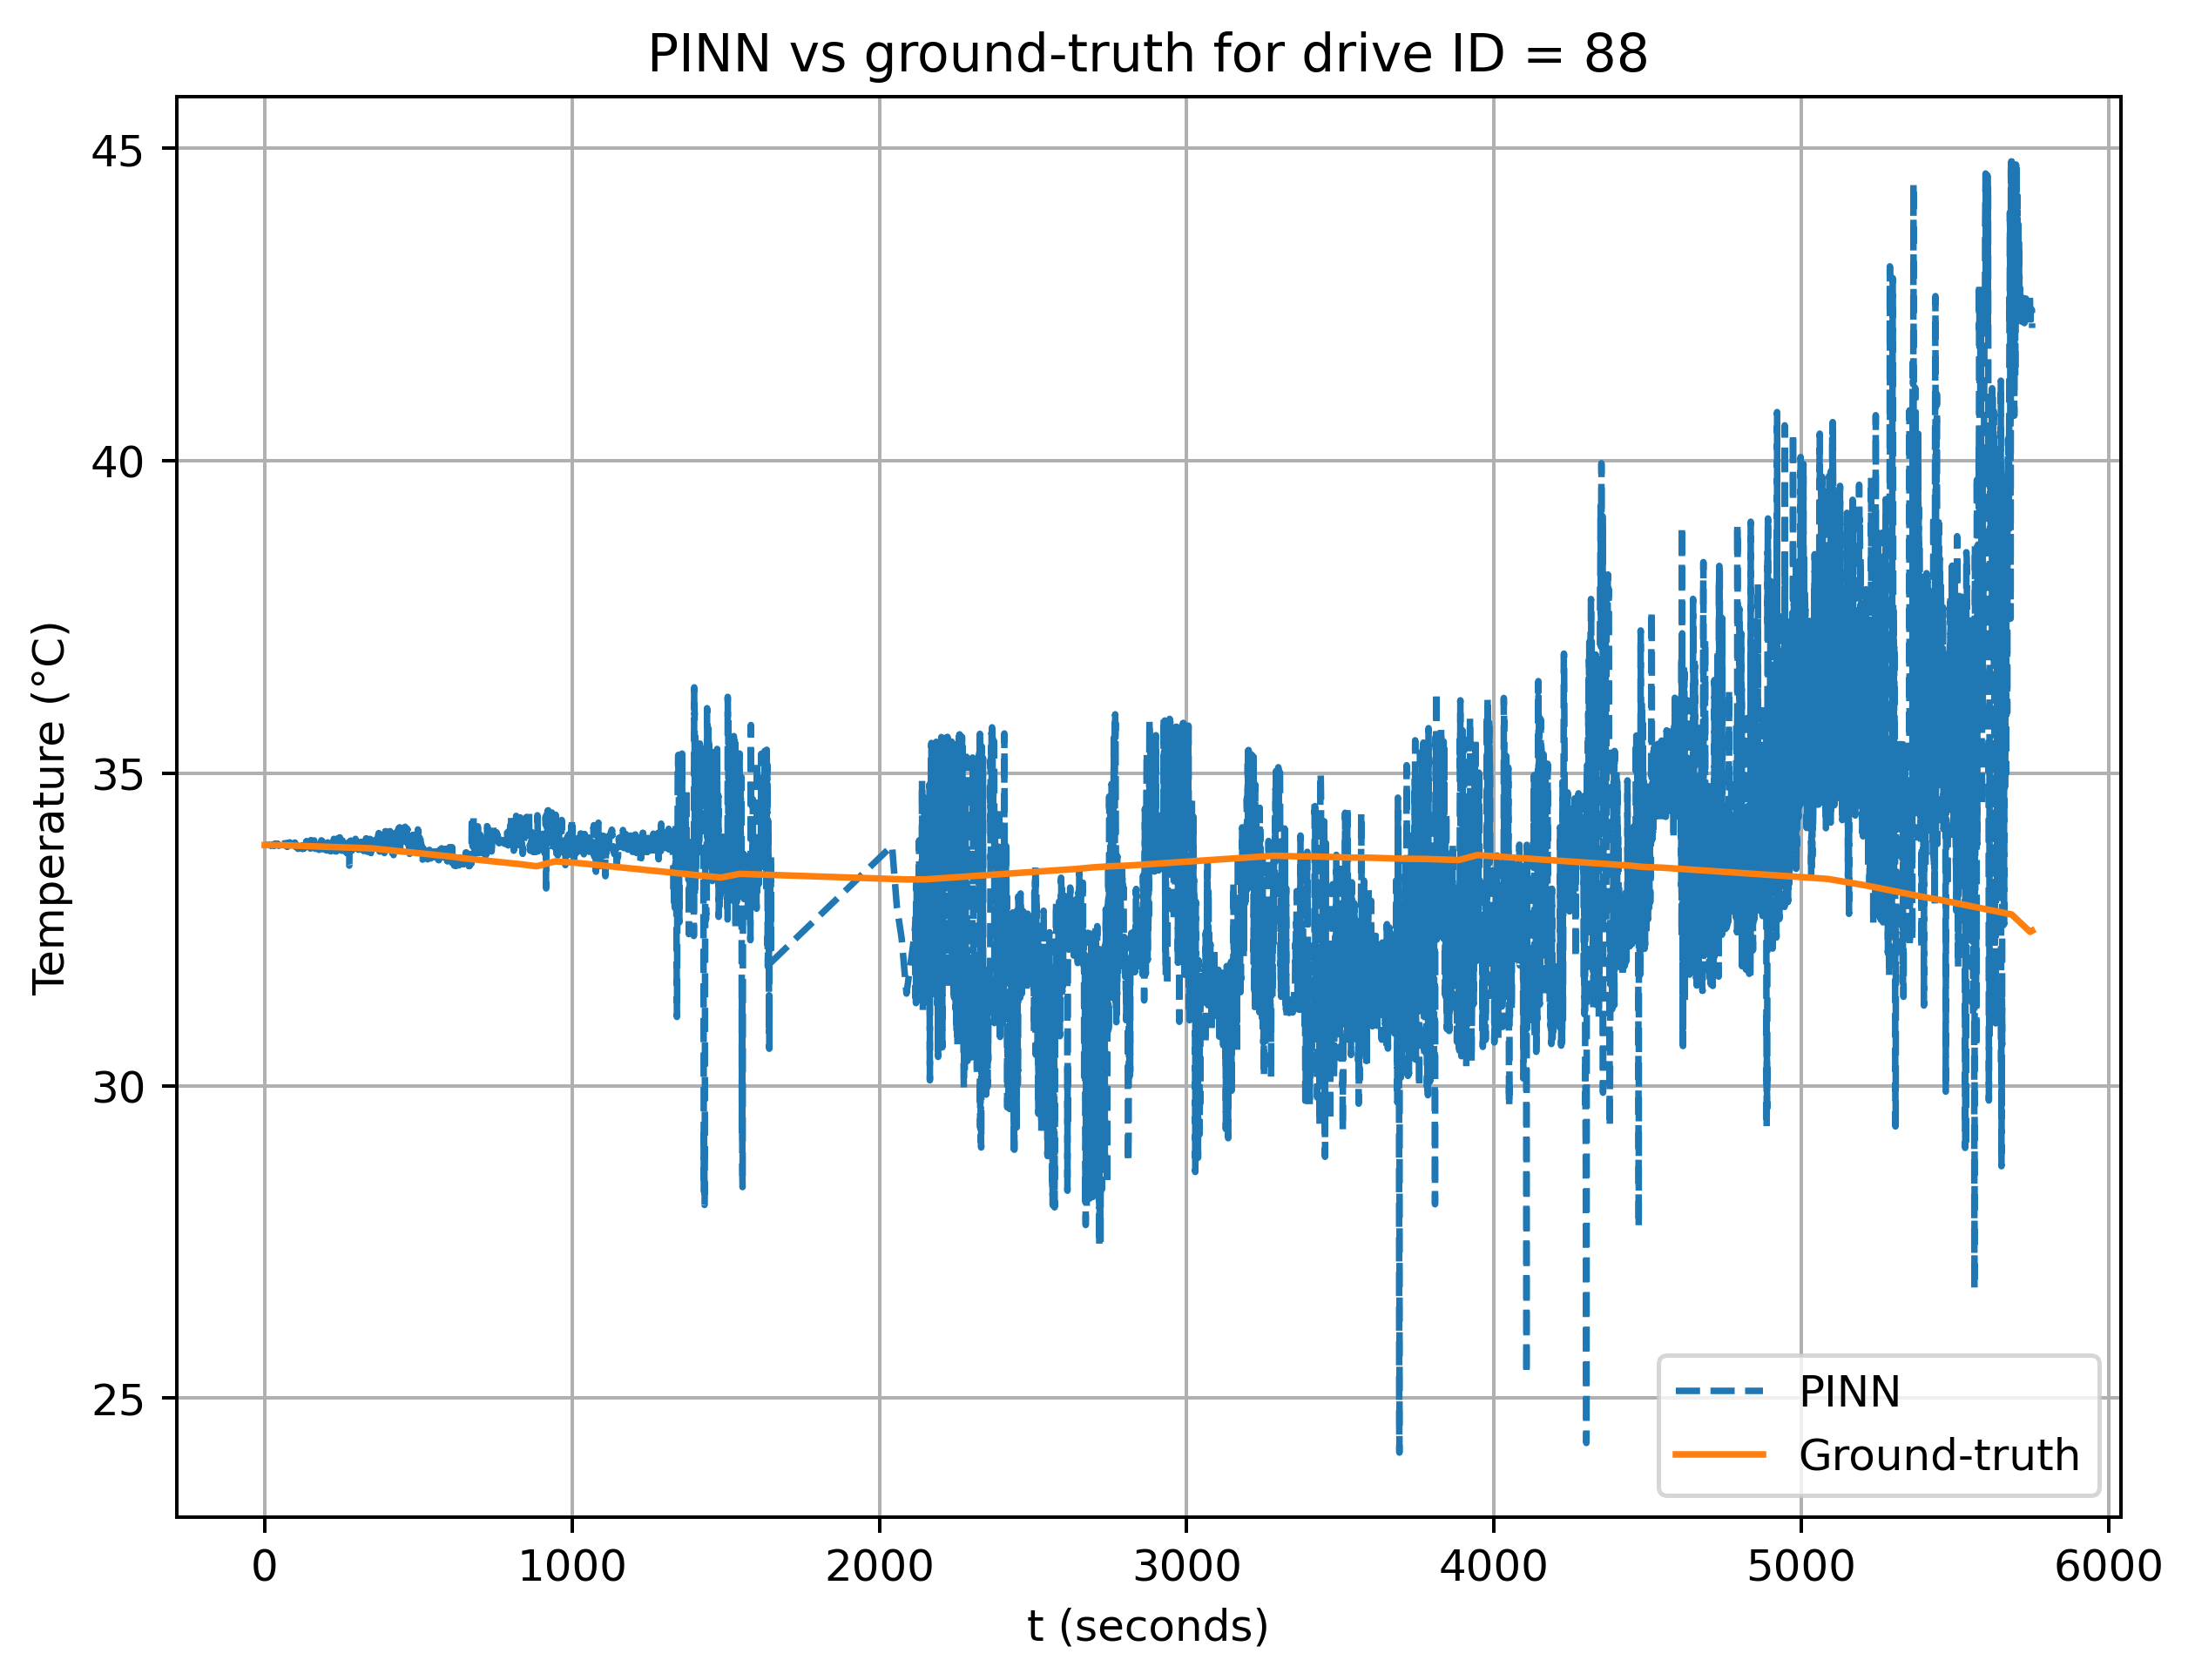

time: 0.07487034797668457
MAE: 0.0020103198
MSE: 9.145903e-06
Relative error (%): 443.4795379638672


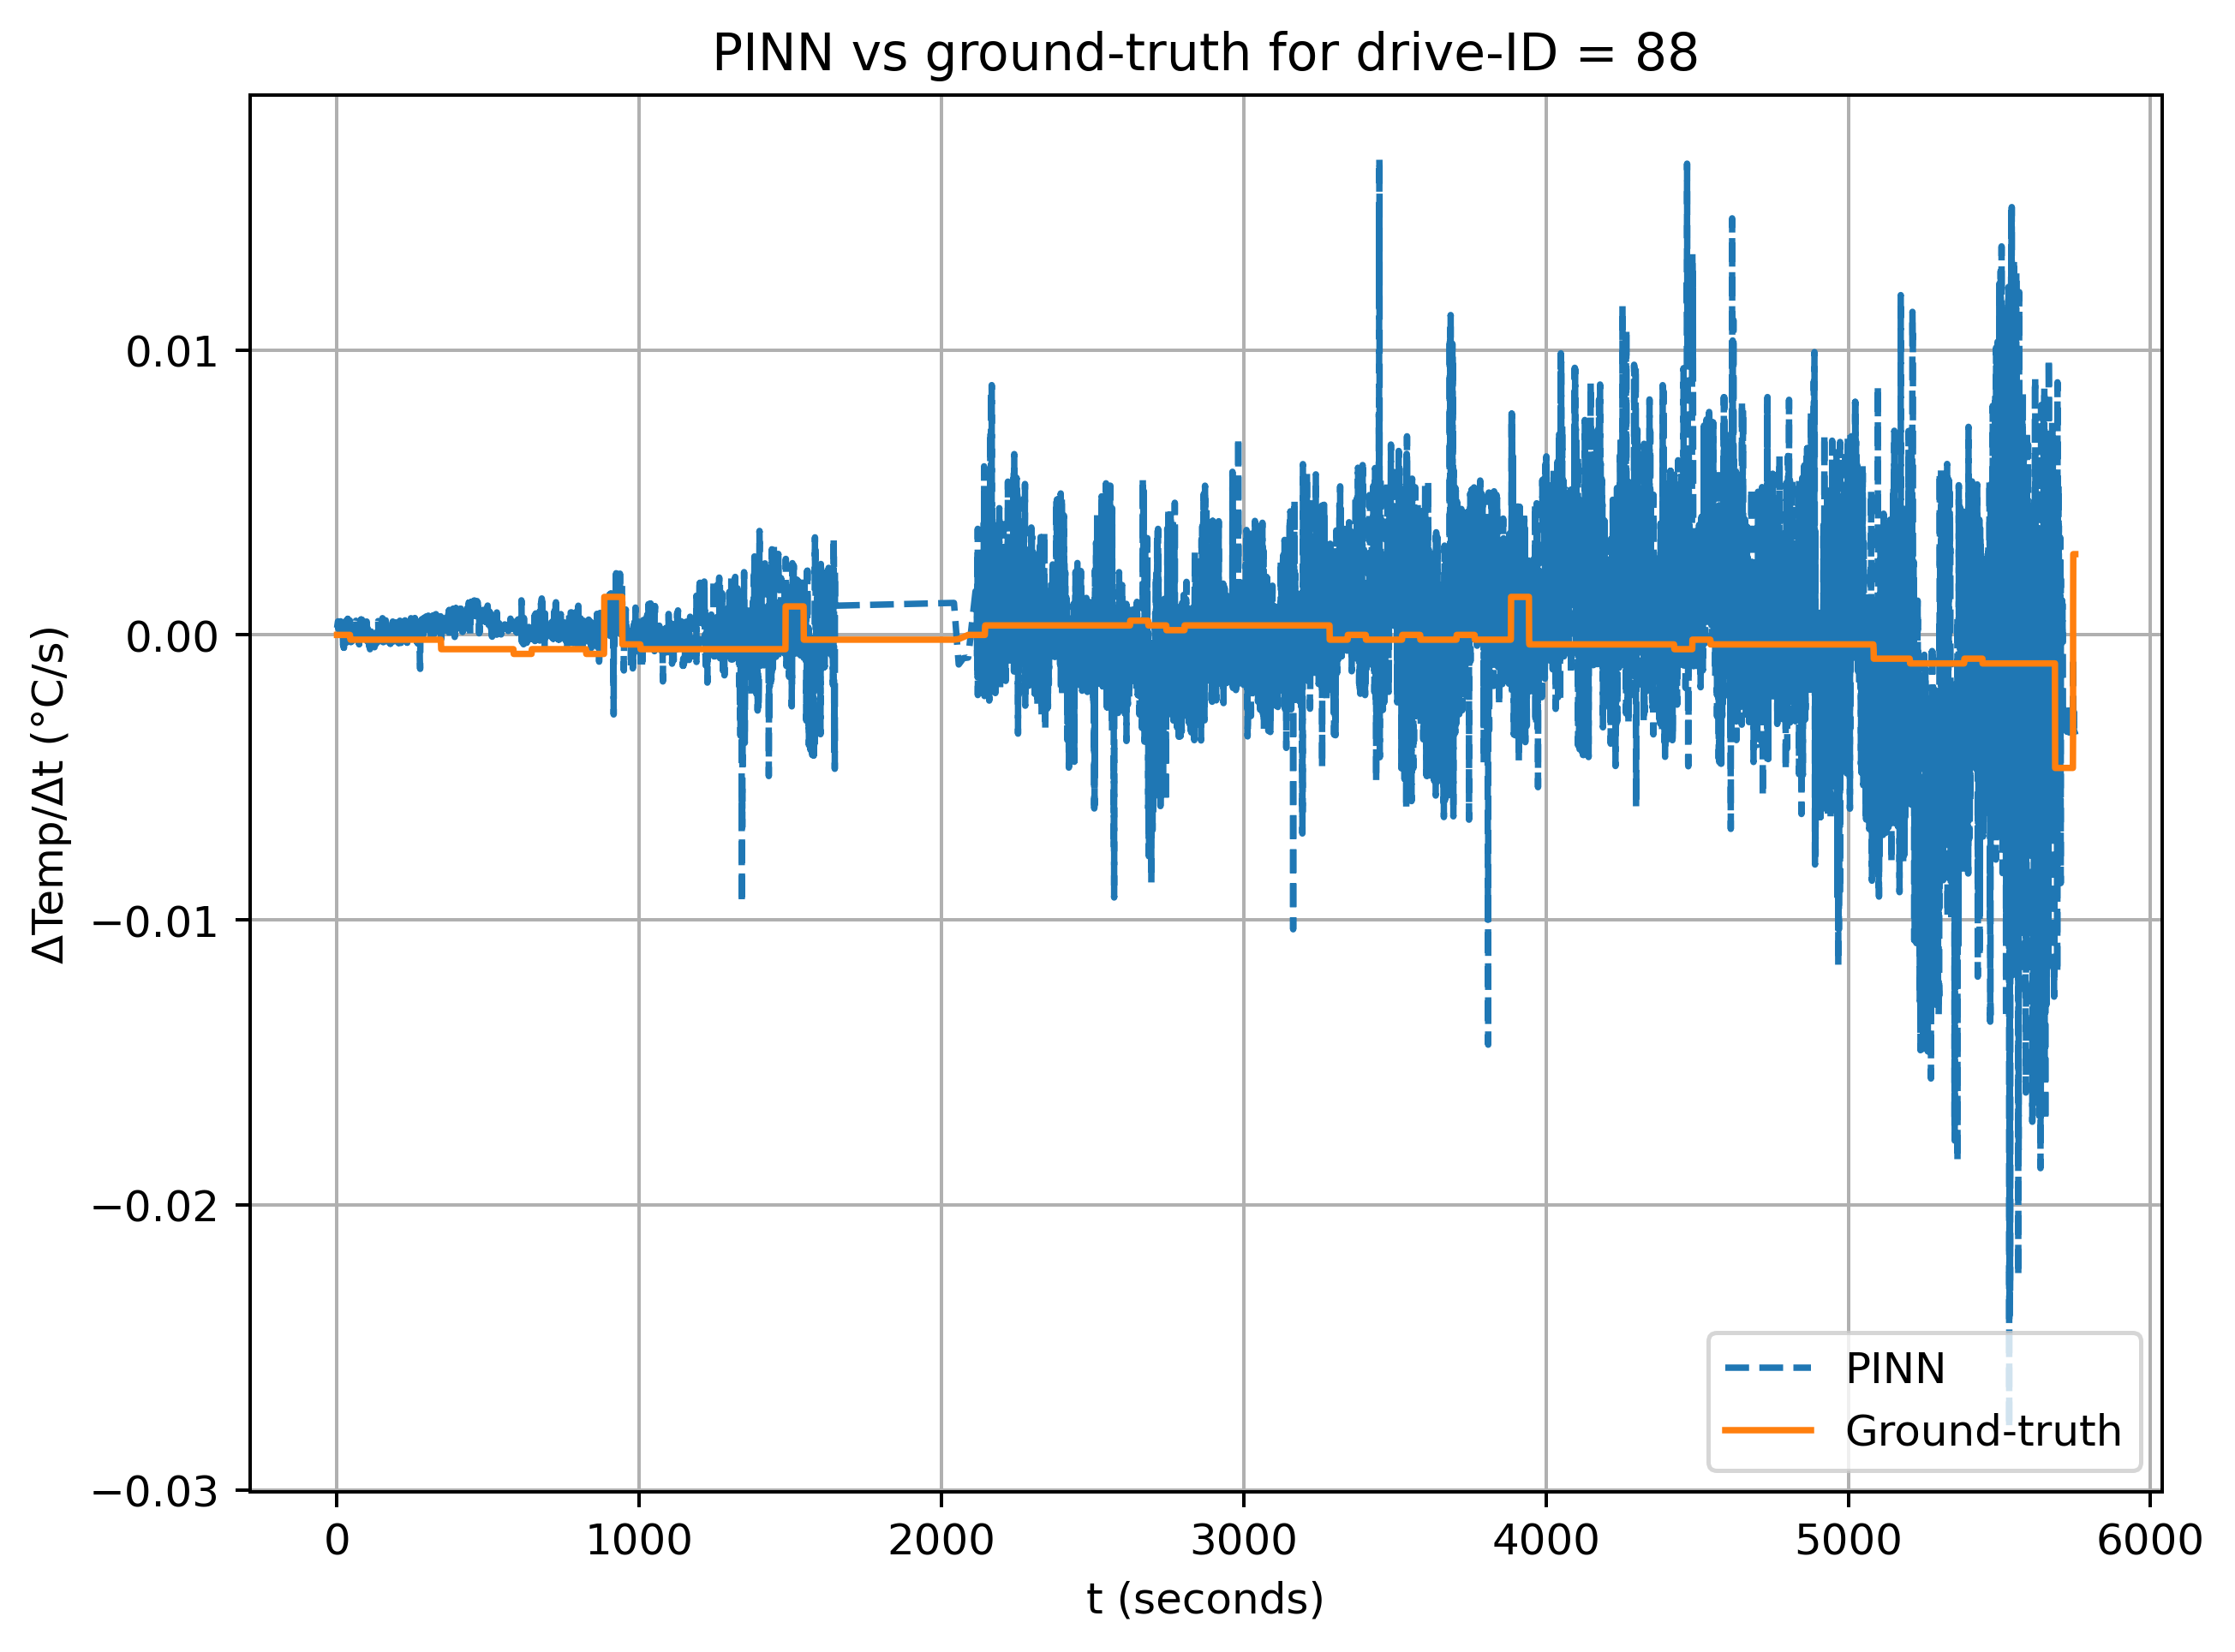

In [31]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=88, bl = bl)